## Proyecto Integrado

Descripción del proyecto
Trabajas para la tienda online Ice que vende videojuegos por todo el mundo. Las reseñas de usuarios y expertos, los géneros, las plataformas (por ejemplo, Xbox o PlayStation) y los datos históricos sobre las ventas de juegos están disponibles en fuentes abiertas. Tienes que identificar patrones que determinen si un juego tiene éxito o no. Esto te permitirá detectar proyectos prometedores y planificar campañas publicitarias.

Delante de ti hay datos que se remontan a 2016. Imaginemos que es diciembre de 2016 y estás planeando una campaña para 2017.

Lo importante es adquirir experiencia de trabajo con datos. Realmente no importa si estás pronosticando las ventas de 2017 en función de los datos de 2016 o las ventas de 2027 en función de los datos de 2026.

El dataset contiene una columna "rating" que almacena la clasificación ESRB de cada juego. El Entertainment Software Rating Board (la Junta de clasificación de software de entretenimiento) evalúa el contenido de un juego y asigna una clasificación de edad como Adolescente o Adulto.

Descripción de datos
* Name (Nombre)
* Platform (Plataforma)
* Year_of_Release (Año de lanzamiento)
* Genre (Género) 
* NA_sales (ventas en Norteamérica en millones de dólares estadounidenses) 
* EU_sales (ventas en Europa en millones de dólares estadounidenses) 
* JP_sales (ventas en Japón en millones de dólares estadounidenses) 
* Other_sales (ventas en otros países en millones de dólares estadounidenses) 
* Critic_Score (máximo de 100) 
* User_Score (máximo de 10) 
* Rating (ESRB)

Es posible que los datos de 2016 estén incompletos.

In [ ]:
# Bibliotecas estándar de Python
import datetime as dt

# Bibliotecas de terceros
import missingno as msno  # Librería para valores faltantes
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
import statsmodels.formula.api as smf

import itertools
import sys
from pathlib import Path

In [2]:
#importamos los datos a nuestra varible df

raw_data = pd.read_csv("../raw/games.csv")
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [ ]:
# Cambiar la ruta a la carpeta del módulo
functions_path = Path("../functions_RoCCO")
sys.path.append(str(functions_path))

# Importar la función
from util_functions import *


In [4]:
#missing_case_summary(raw_data)
missing_data_by_column(raw_data)

,variable,n_missing,n_cases,complete_cases,pct_missing
8,Critic_Score,8578,16715,8137,51.3192
10,Rating,6766,16715,9949,40.4786
9,User_Score,6701,16715,10014,40.0897
2,Year_of_Release,269,16715,16446,1.6093
0,Name,2,16715,16713,0.0120
3,Genre,2,16715,16713,0.0120
1,Platform,0,16715,16715,0.0000
6,JP_sales,0,16715,16715,0.0000
5,EU_sales,0,16715,16715,0.0000
4,NA_sales,0,16715,16715,0.0000


<Figure size 1000x600 with 0 Axes>

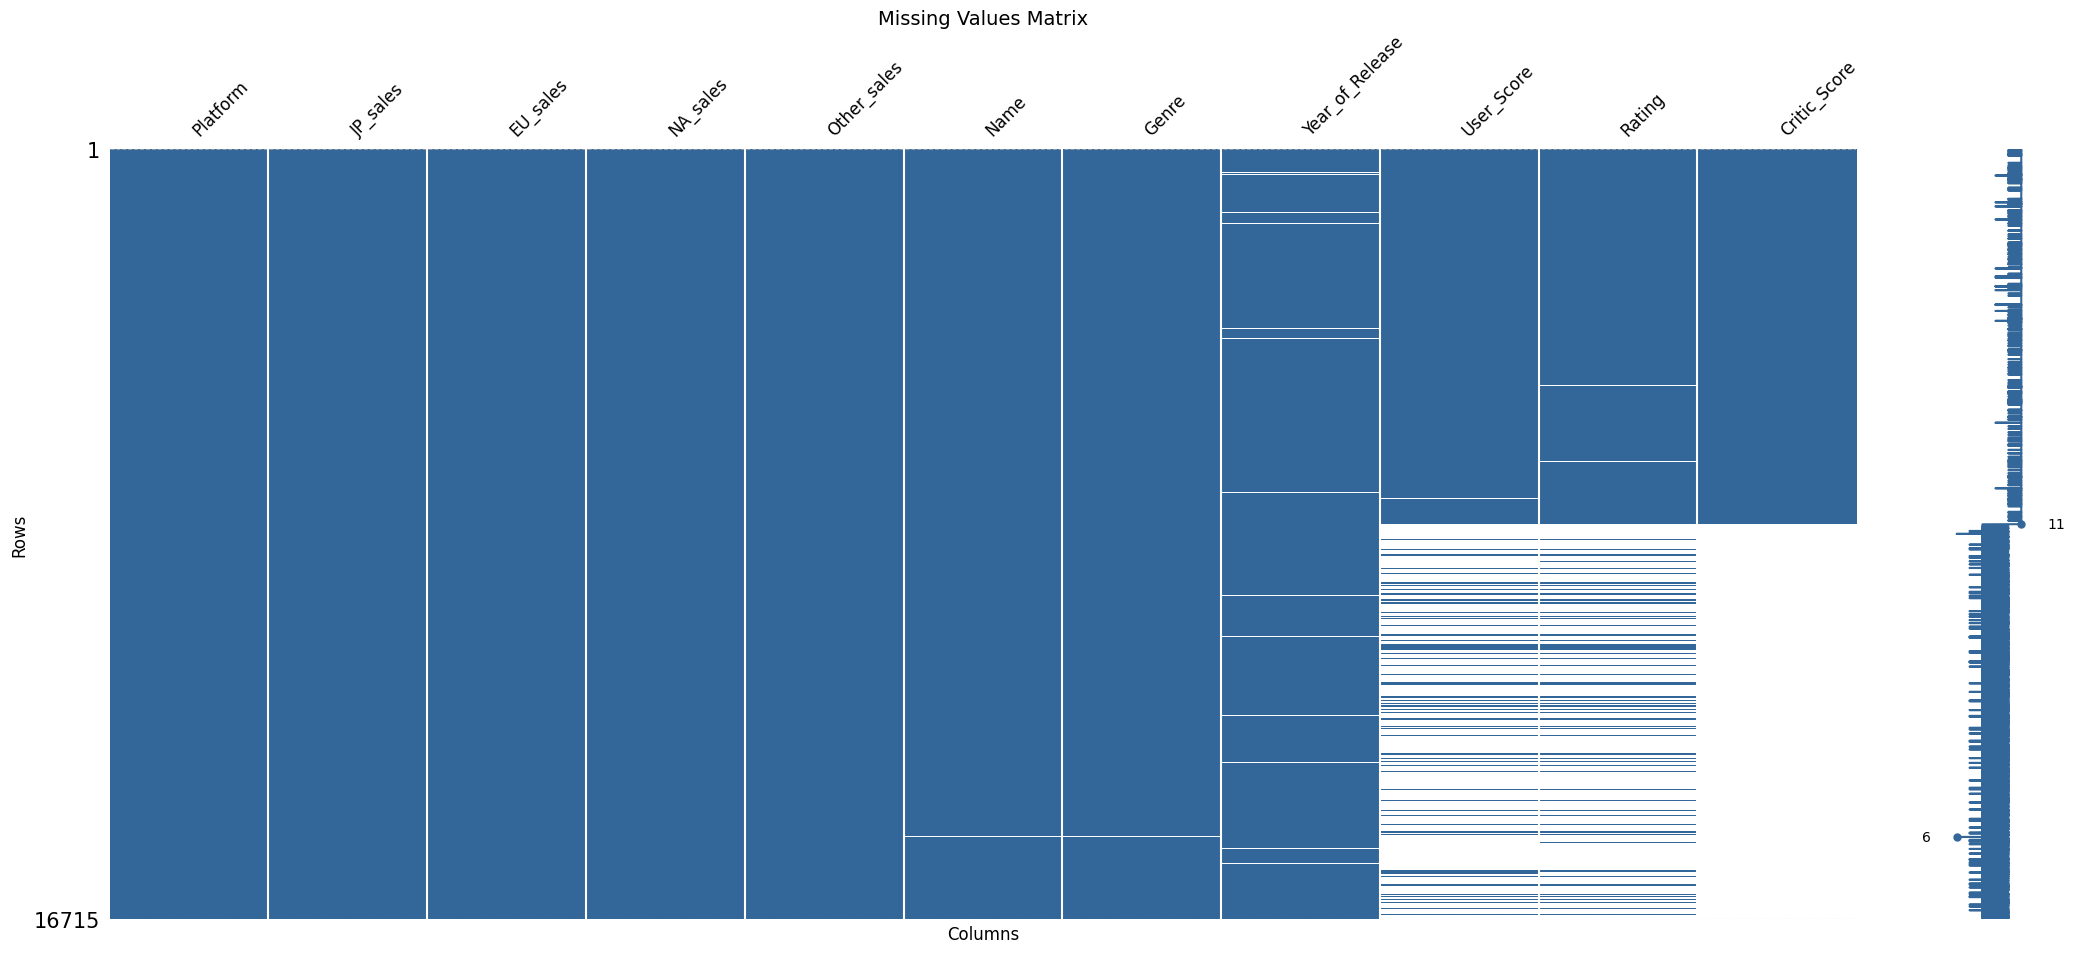

In [5]:
plot_missing_values_matrix(raw_data,sort_rows_by='Critic_Score')

## Paso 1. Abre el archivo de datos y estudia la información general 

### Reemplaza los nombres de las columnas (ponlos en minúsculas).


In [6]:
#Cambiamos nombres de los campos a minuscula
raw_data.columns = raw_data.columns.str.lower()
raw_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


#### Convertimos los datos en los tipos necesarios.

In [7]:
# cambiamos el tipo de dato a datetime pero al solo ser año lo cambiamos a float
raw_data['year_of_release'] = pd.to_datetime(raw_data['year_of_release'],format='%Y') 
raw_data['year_of_release'] = raw_data['year_of_release'].dt.year

# cambiamos el tipo de dato de genre y platform a category
raw_data[['genre','platform','rating']] = raw_data[['genre','platform','rating']].astype('category') 

raw_data = raw_data.replace({'tbd':np.nan}) # cambiamos los valores de tbd a Nan
raw_data['user_score']=pd.to_numeric(raw_data['user_score']) # convertimos la columna user_score a float

raw_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16713 non-null  object  
 1   platform         16715 non-null  category
 2   year_of_release  16446 non-null  float64 
 3   genre            16713 non-null  category
 4   na_sales         16715 non-null  float64 
 5   eu_sales         16715 non-null  float64 
 6   jp_sales         16715 non-null  float64 
 7   other_sales      16715 non-null  float64 
 8   critic_score     8137 non-null   float64 
 9   user_score       7590 non-null   float64 
 10  rating           9949 non-null   category
dtypes: category(3), float64(7), object(1)
memory usage: 1.1+ MB


In [8]:
#resumen de valores faltantes y porcentajes por columna
missing_data_by_column(raw_data)

,variable,n_missing,n_cases,complete_cases,pct_missing
9,user_score,9125,16715,7590,54.5917
8,critic_score,8578,16715,8137,51.3192
10,rating,6766,16715,9949,40.4786
2,year_of_release,269,16715,16446,1.6093
0,name,2,16715,16713,0.0120
3,genre,2,16715,16713,0.0120
1,platform,0,16715,16715,0.0000
6,jp_sales,0,16715,16715,0.0000
5,eu_sales,0,16715,16715,0.0000
4,na_sales,0,16715,16715,0.0000


In [9]:
summarize_missing_cases(raw_data)

,n_missing_in_case,n_cases,pct_case
0,0,6826,40.84
1,3,6607,39.53
2,1,1819,10.88
3,2,1376,8.23
4,4,85,0.51
5,5,2,0.01


In [10]:
#Cuantos valores faltantes por Variable (columna) y sus porcentajes
summarize_missing_values(raw_data)

,n_missing_in_variable,n_variables,pct_variables
0,0,5,45.45
1,2,2,18.18
2,269,1,9.09
3,6766,1,9.09
4,8578,1,9.09
5,9125,1,9.09


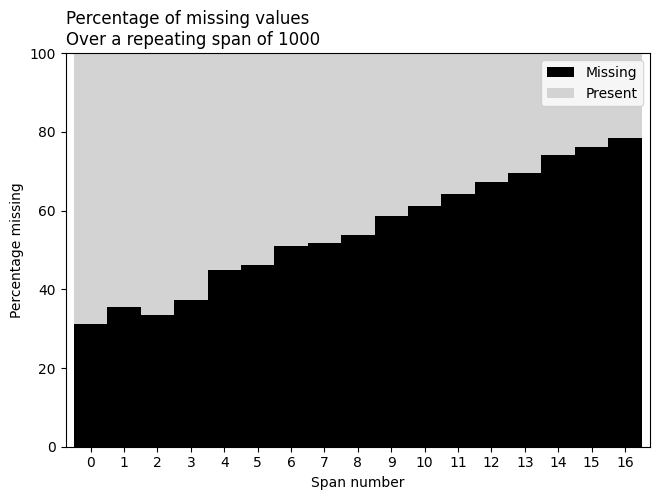

,span_counter,n_missing,n_complete,pct_missing,pct_complete
0,0,312,688,31.20,68.80
1,1,356,644,35.60,64.40
2,2,334,666,33.40,66.60
3,3,373,627,37.30,62.70
4,4,449,551,44.90,55.10
5,5,461,539,46.10,53.90
6,6,511,489,51.10,48.90
7,7,518,482,51.80,48.20
8,8,539,461,53.90,46.10
9,9,586,414,58.60,41.40


In [11]:
#revisar variaciones de datos faltantes con span, para ver si hay concentraciones de datos en algun grupo en particular y grafico para critic_score
summarize_missing_by_span(raw_data, variable='user_score', span_every = 1000, rot=0)

<Figure size 1000x600 with 0 Axes>

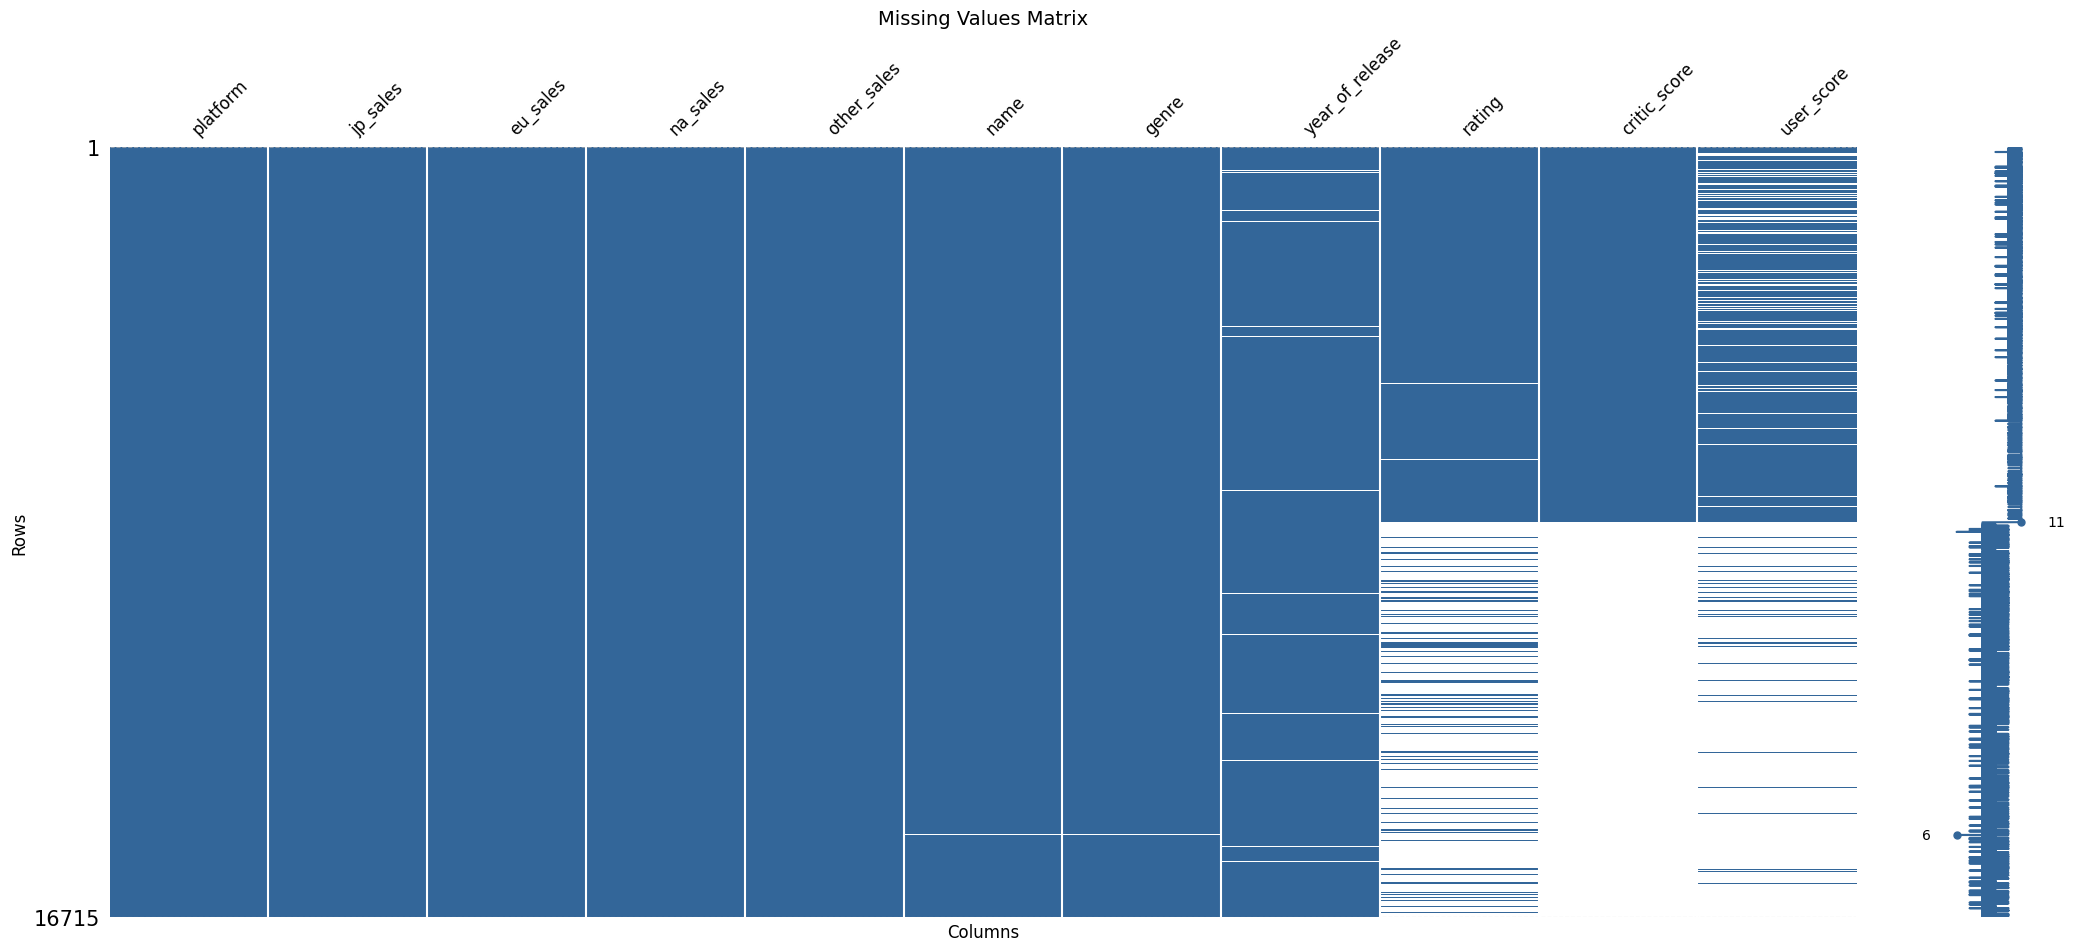

In [12]:
plot_missing_values_matrix(raw_data, sort_rows_by='critic_score')

<Figure size 1000x600 with 0 Axes>

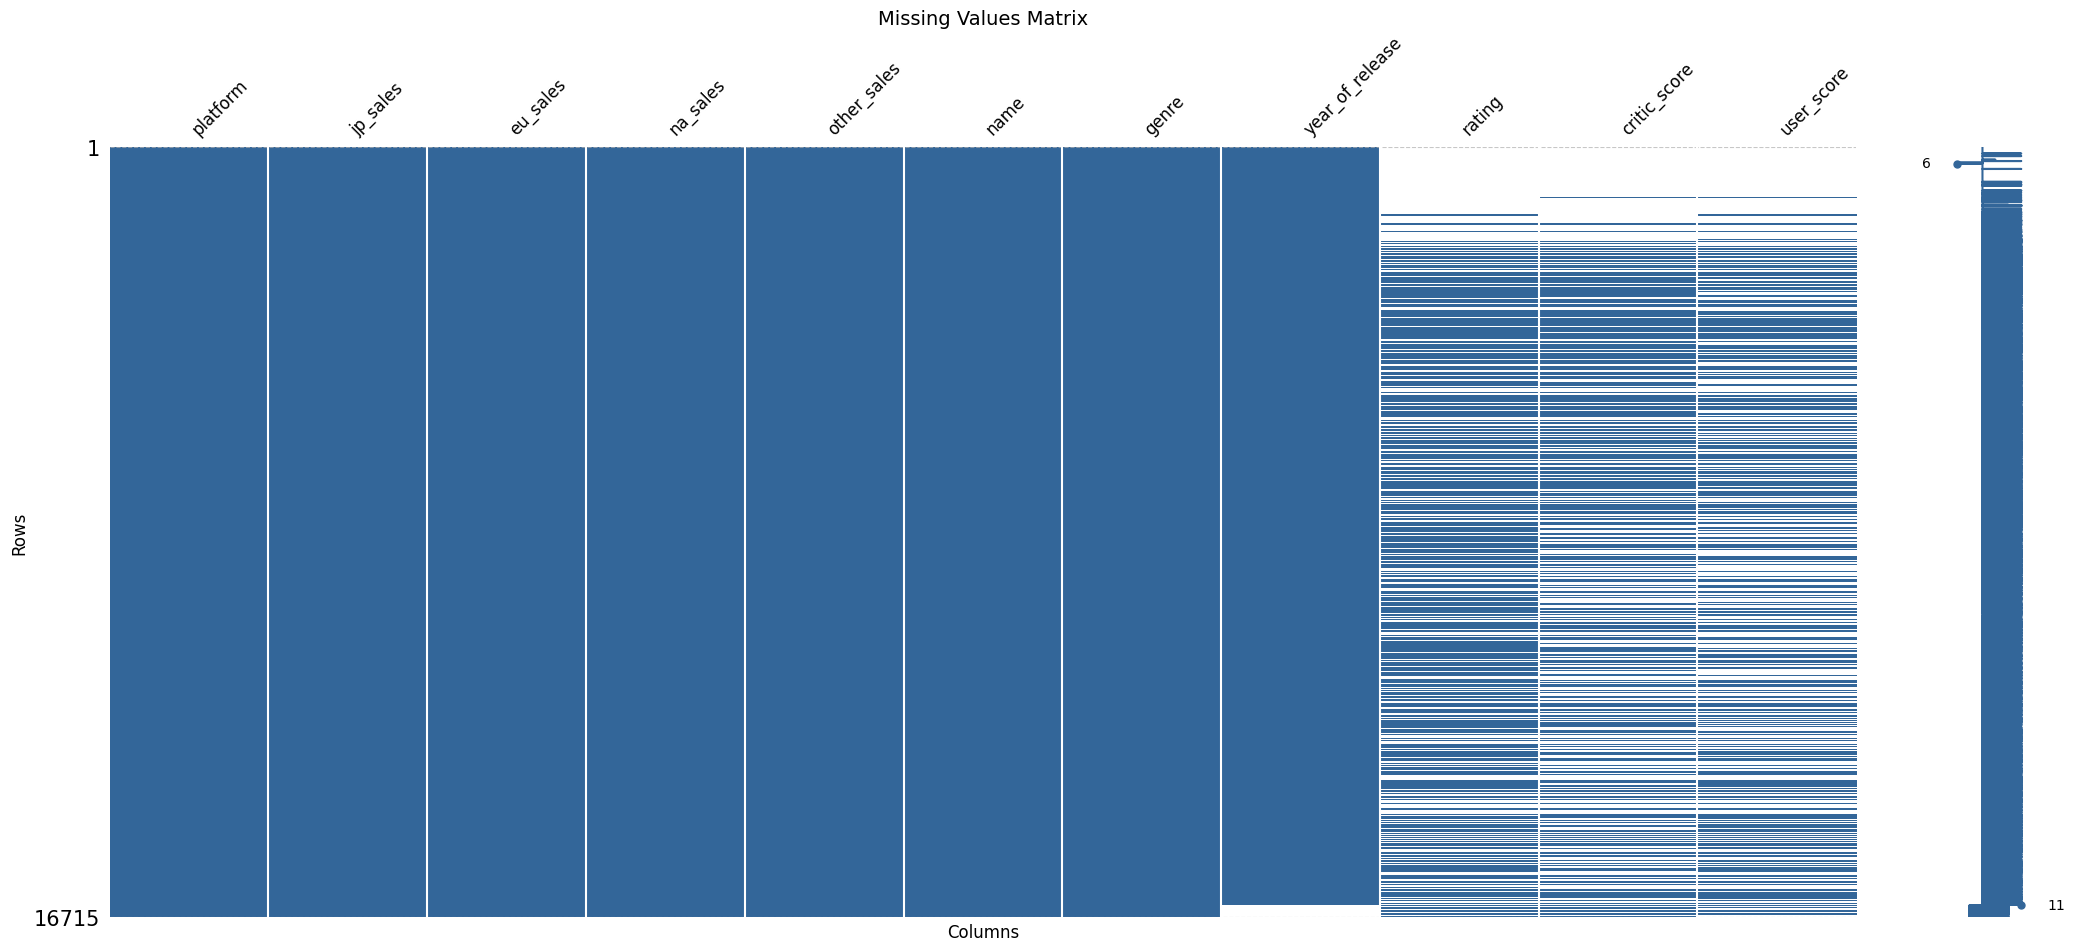

In [13]:
plot_missing_values_matrix(raw_data, sort_rows_by='year_of_release')

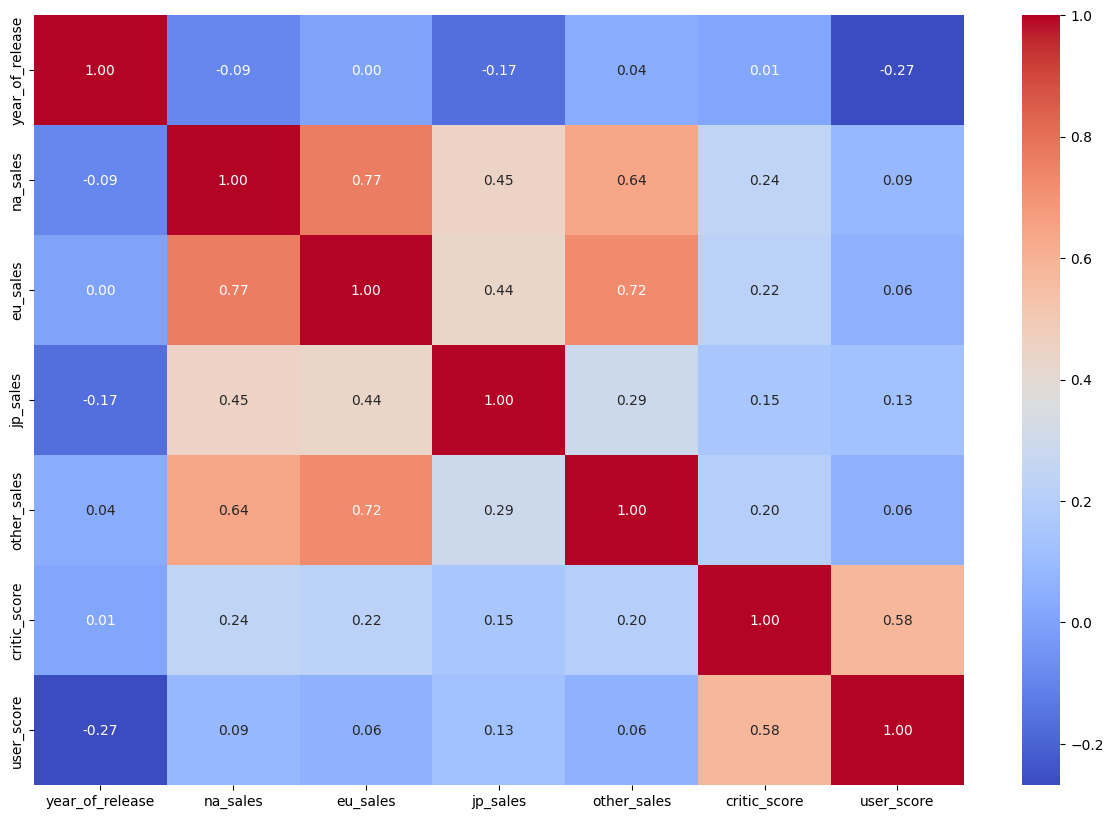

In [14]:
# Hacemos una matrix de correlaciones con seaborn para ver las relaciones entre las diferentes variables

raw_data_numeric = raw_data.select_dtypes(exclude=['category','object','datetime'])
matrix_correlation(raw_data_numeric, figsize=(15,10))


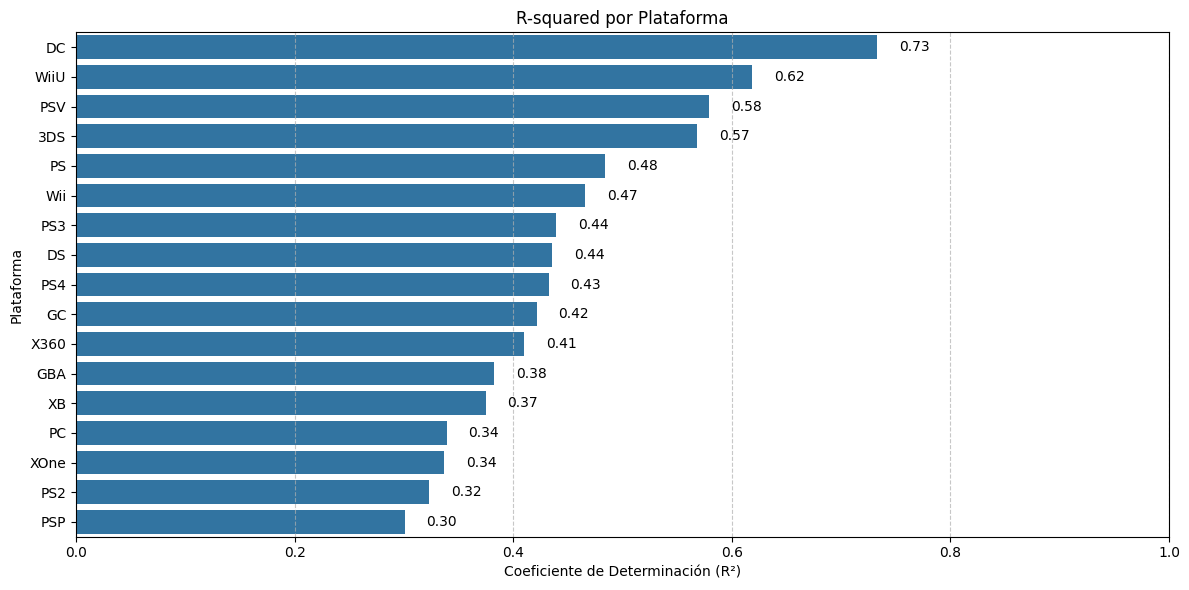

In [15]:
# Lista de plataformas únicas en los datos
list_platform = raw_data['platform'].unique()

# Diccionario para almacenar R-squared de cada plataforma
r_squared_dict = {}

for platform in list_platform:
    # Filtrar datos para la plataforma y seleccionar columnas numéricas
    raw_data_prueba = raw_data[raw_data['platform'] == platform].select_dtypes(exclude=['category', 'object', 'datetime'])
    
    # Verificar que hay al menos 20 observaciones antes de ajustar el modelo
    if raw_data_prueba.shape[0] < 20:
        continue
    
    try:
        # Ajustar el modelo de regresión
        model = smf.ols(
            formula='user_score ~ eu_sales + na_sales + jp_sales + other_sales + critic_score',
            data=raw_data_prueba
        ).fit()

        r_squared = model.rsquared  # Obtener R²
        r_squared_dict[platform] = r_squared

    except Exception as e:
        continue

# Crear DataFrame con los resultados
df_r2 = pd.DataFrame(list(r_squared_dict.items()), columns=['Plataforma', 'R-squared'])

# Ordenar el DataFrame de mayor a menor R-squared
df_r2 = df_r2.sort_values(by="R-squared", ascending=False)

# Visualizar resultados con un gráfico de barras horizontales
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='R-squared', y='Plataforma', data=df_r2)
plt.xlabel("Coeficiente de Determinación (R²)")
plt.ylabel("Plataforma")
plt.title("R-squared por Plataforma")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Anotar el valor de R-squared al lado de cada barra
for index, row in df_r2.reset_index().iterrows():
    ax.text(row['R-squared'] + 0.02, index, f"{row['R-squared']:.2f}", color='black', va='center')

plt.tight_layout()
plt.show()


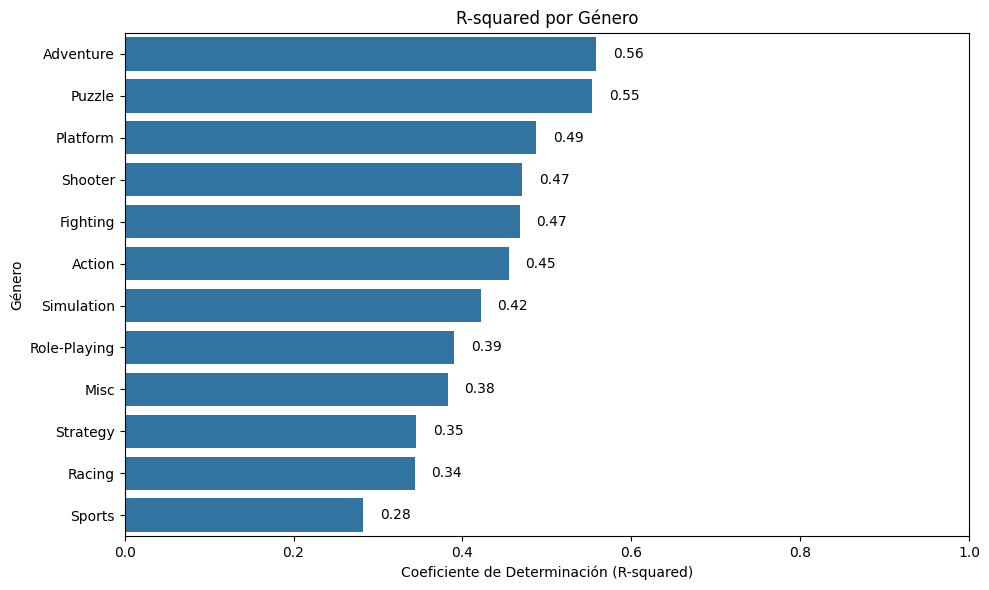

In [16]:
# Obtener los géneros únicos
list_genre = raw_data['genre'].unique()

# Lista para almacenar los resultados (género y R-squared)
results = []

for genre in list_genre:
    # Filtrar datos para el género y seleccionar columnas numéricas
    raw_data_prueba = raw_data[raw_data['genre'] == genre].select_dtypes(exclude=['category', 'object', 'datetime'])
    
    try:
        # Ajustar el modelo
        model = smf.ols(
            formula='critic_score ~ eu_sales + na_sales + jp_sales + other_sales + user_score',
            data=raw_data_prueba
        ).fit()
        
        # Obtener R-squared
        r_squared = model.rsquared
        
        # Almacenar el resultado
        results.append((genre, r_squared))
        
    except Exception as e:
        continue

# Convertir la lista de resultados en un DataFrame y ordenar de mayor a menor R-squared
df_results = pd.DataFrame(results, columns=['genre', 'r_squared'])
df_results = df_results.sort_values(by='r_squared', ascending=False).reset_index(drop=True)

# Crear el gráfico de barras horizontales con seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='r_squared', y='genre', data=df_results)
plt.xlabel("Coeficiente de Determinación (R-squared)")
plt.ylabel("Género")
plt.title("R-squared por Género")
plt.xlim(0, 1)
plt.tight_layout()

# Agregar anotaciones: para cada barra se muestra el valor del R-squared
for p in ax.patches:
    width = p.get_width()
    # Posicionar el texto al final de la barra con un pequeño margen
    ax.text(width + 0.02, p.get_y() + p.get_height()/2,
            f"{width:.2f}", ha='left', va='center', fontsize=10)

plt.show()


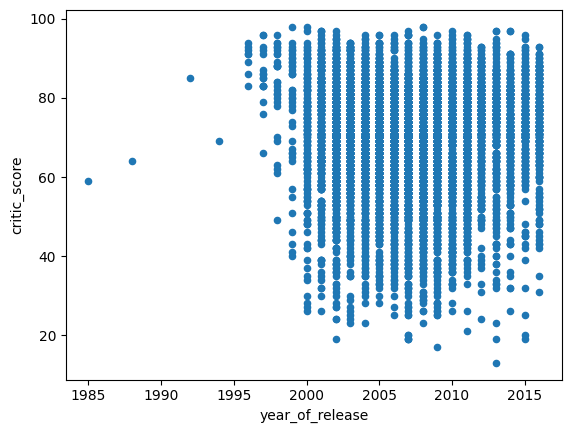

In [17]:
#mostramos los datos de Critic_score a lo largo de los años

(
    raw_data[['year_of_release','critic_score']]
    .plot(kind='scatter', x='year_of_release', y='critic_score')
)
plt.show()

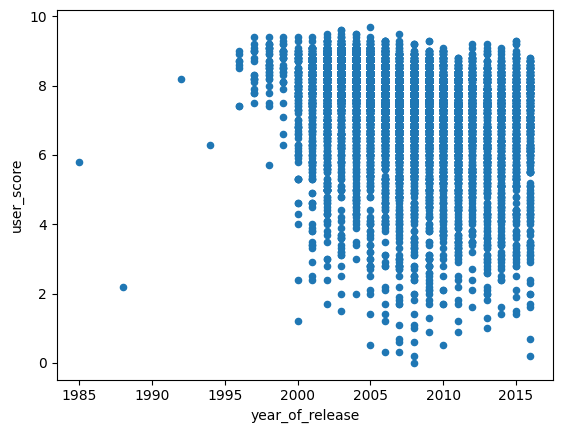

In [18]:
#mostramos los datos de user_score a lo largo de los años

(
    raw_data[['year_of_release','user_score']]
    .plot(kind='scatter', x='year_of_release', y='user_score')
)
plt.show()

### Preprocesamiento de datos

In [19]:
raw_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16713 non-null  object  
 1   platform         16715 non-null  category
 2   year_of_release  16446 non-null  float64 
 3   genre            16713 non-null  category
 4   na_sales         16715 non-null  float64 
 5   eu_sales         16715 non-null  float64 
 6   jp_sales         16715 non-null  float64 
 7   other_sales      16715 non-null  float64 
 8   critic_score     8137 non-null   float64 
 9   user_score       7590 non-null   float64 
 10  rating           9949 non-null   category
dtypes: category(3), float64(7), object(1)
memory usage: 1.1+ MB


In [20]:
raw_data[raw_data.duplicated()] # No tenemos duplicados

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Comentarios:
- La columna 'year_of_release' debemos convertirla object a float.
- Las columnas 'user_score' y 'critic_score' de object a float
- Las columnas 'platform' y 'genre' a category
- En vista que tenemos valores ausentes en el orden de 8K en 'critic_score', 'user_score' y 'rating' vs los 16K de registros, solo tomaremos los valores ausentes, procedere a eliminarlos y trabajar sin ellos para mas adelante intentar imputar los que sea razonablemente posible.


In [21]:
raw_data_2000=raw_data[raw_data['year_of_release']>2000]
raw_data_2000

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [22]:
missing_data_by_column(raw_data_2000)

,variable,n_missing,n_cases,complete_cases,pct_missing
9,user_score,6856,14120,7264,48.5552
8,critic_score,6376,14120,7744,45.1558
10,rating,4605,14120,9515,32.6133
2,year_of_release,0,14120,14120,0.0000
1,platform,0,14120,14120,0.0000
0,name,0,14120,14120,0.0000
3,genre,0,14120,14120,0.0000
6,jp_sales,0,14120,14120,0.0000
5,eu_sales,0,14120,14120,0.0000
4,na_sales,0,14120,14120,0.0000


<Figure size 1000x600 with 0 Axes>

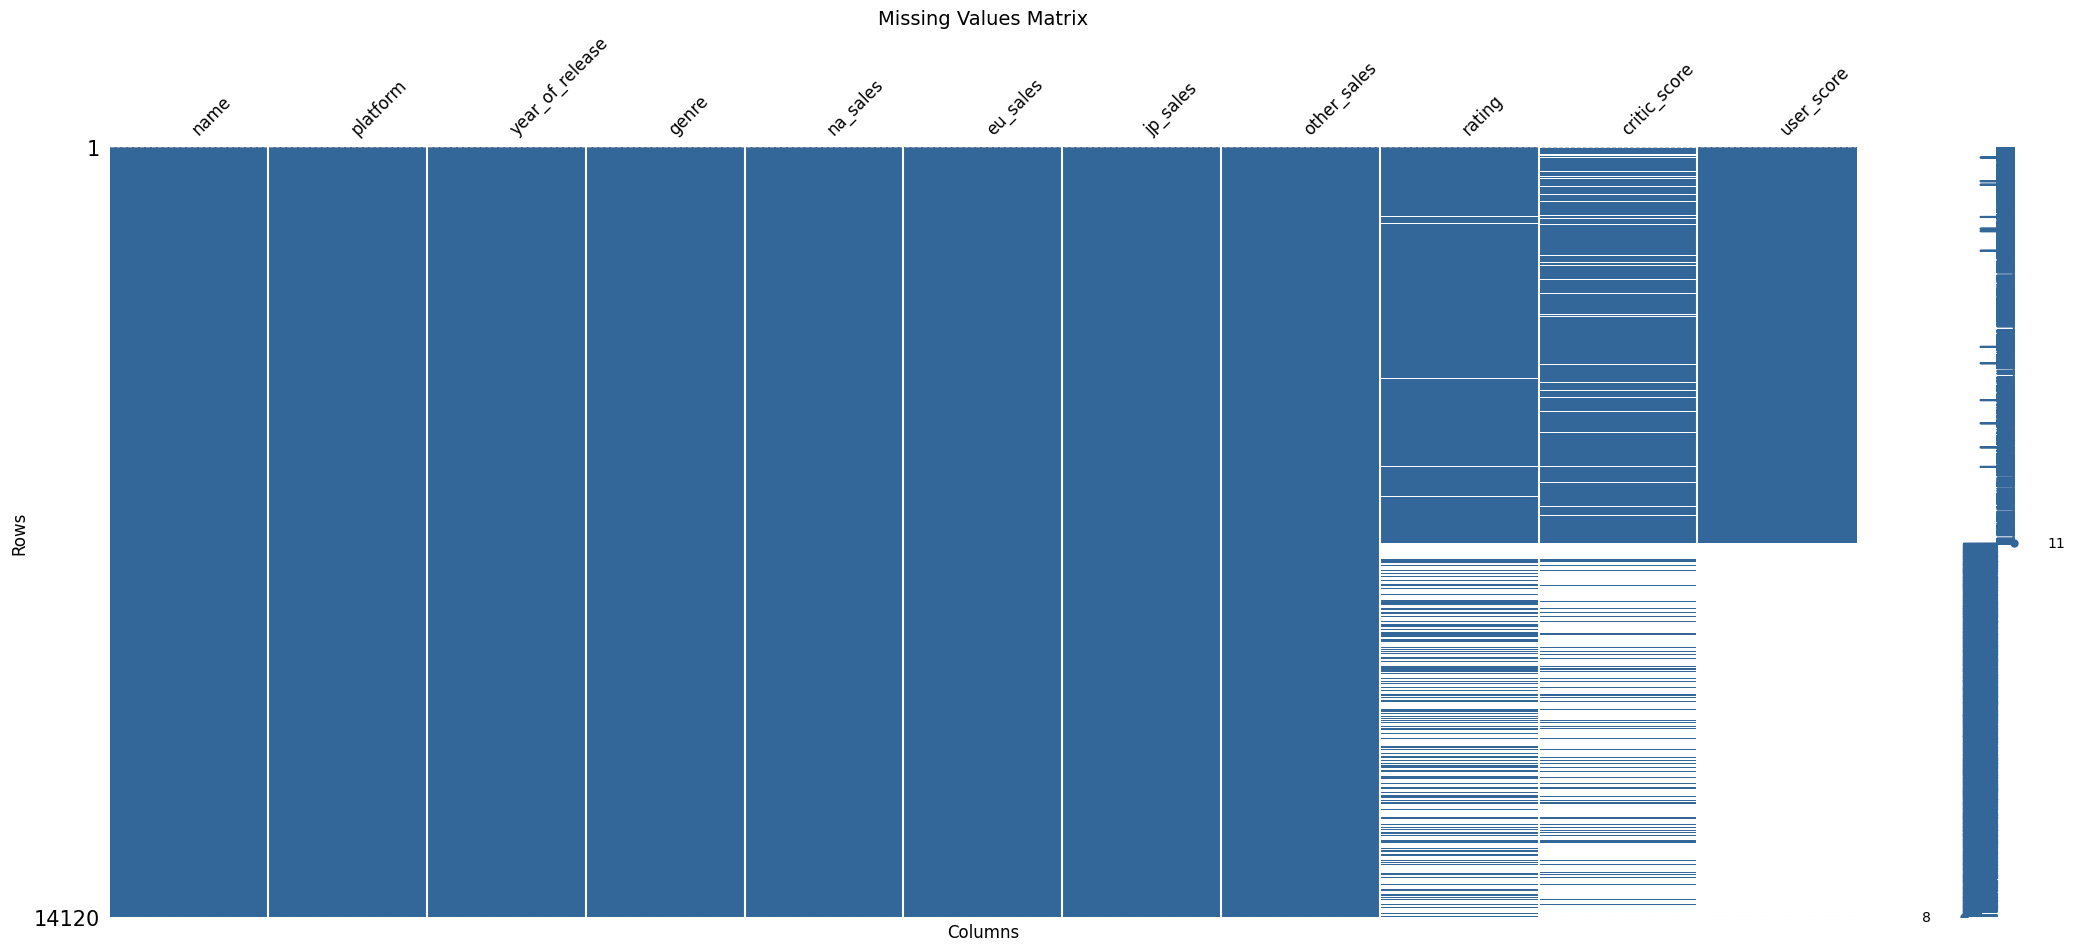

In [23]:
# Valores faltantes con user_critic ordenado
plot_missing_values_matrix(raw_data_2000, sort_rows_by='user_score')

<Figure size 1000x600 with 0 Axes>

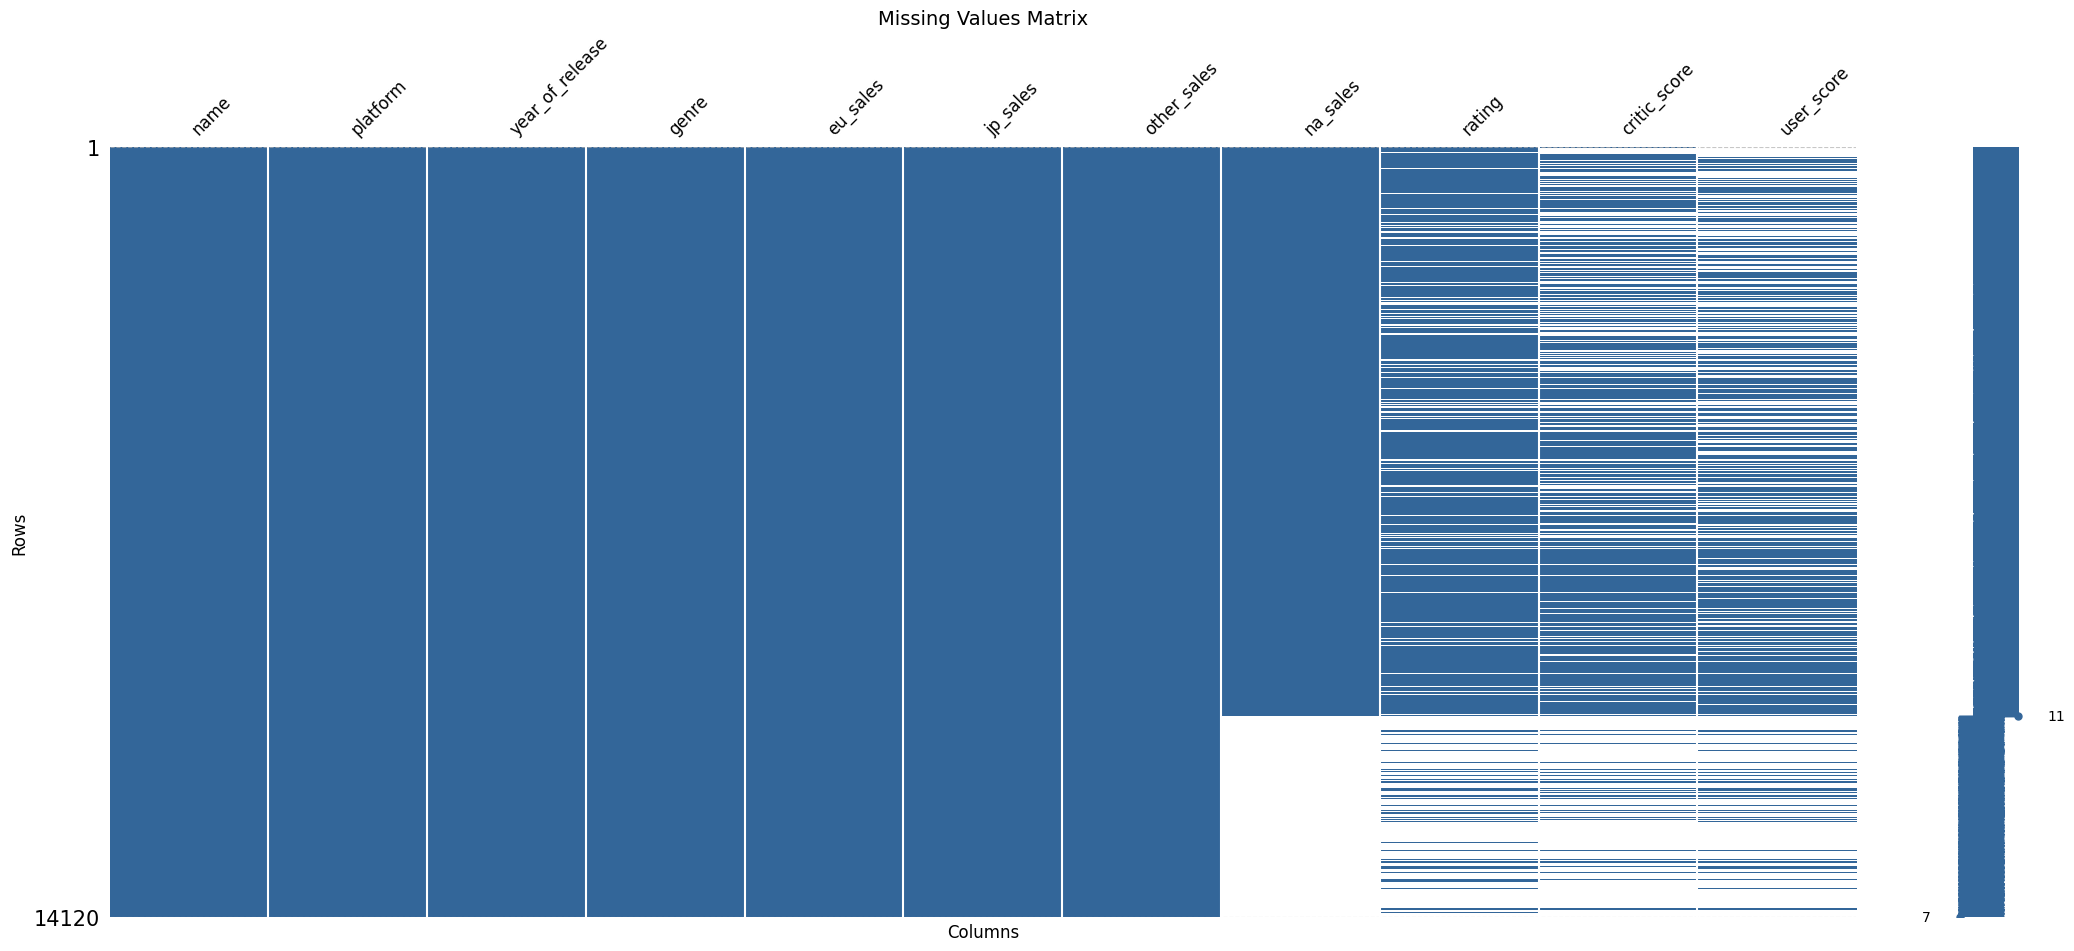

In [24]:
# Verificamos si los ventas na_sales esta relacionado con critic_score, user_score y rating
df_na = raw_data_2000.copy()
df_na['na_sales'] = raw_data_2000['na_sales'].replace(0,np.nan)
plot_missing_values_matrix(df_na, sort_rows_by='na_sales')

In [25]:
# relacion de correlacion mas fuerte es entre user_score y critic_score, aqui vemos cuantos datos podriamos imputar apartir de uno al otro y viceversa 1693
raw_data[(raw_data['critic_score'].notna() & raw_data['user_score'].isna()) | (raw_data['user_score'].notna() & raw_data['critic_score'].isna())].count()

name               1693
platform           1693
year_of_release    1658
genre              1693
na_sales           1693
eu_sales           1693
jp_sales           1693
other_sales        1693
critic_score       1120
user_score          573
rating             1664
dtype: int64

In [26]:
# Aqui vemos que 3000 registros tienen valores NAN para Critic score y User score debido a que en Na_sales no tiene ventas.  El mercado mas importante es NA luego EU 
raw_data_2000[((raw_data_2000['na_sales']==0) & (raw_data_2000['eu_sales']==0)) & raw_data_2000['critic_score'].isna() & raw_data_2000['user_score'].isna()].count

<bound method DataFrame.count of                                                    name platform  \
215                            Monster Hunter Freedom 3      PSP   
340                                   Friend Collection       DS   
385                                    Monster Hunter 4      3DS   
563                              Yokai Watch 2 Shinuchi      3DS   
694                                 Yokai Watch Busters      3DS   
...                                                 ...      ...   
16707                                  Aiyoku no Eustia      PSV   
16709  SCORE International Baja 1000: The Official Game      PS2   
16710                     Samurai Warriors: Sanada Maru      PS3   
16712                           Haitaka no Psychedelica      PSV   
16714                               Winning Post 8 2016      PSV   

       year_of_release         genre  na_sales  eu_sales  jp_sales  \
215             2010.0  Role-Playing       0.0       0.0      4.87   
340       

In [27]:
raw_data_2000[(raw_data_2000['na_sales']==0) & raw_data_2000['critic_score'].isna() & raw_data_2000['user_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
215,Monster Hunter Freedom 3,PSP,2010.0,Role-Playing,0.0,0.00,4.87,0.00,NaN,NaN,NaN
340,Friend Collection,DS,2009.0,Misc,0.0,0.00,3.67,0.00,NaN,NaN,NaN
385,Monster Hunter 4,3DS,2013.0,Role-Playing,0.0,0.00,3.44,0.00,NaN,NaN,NaN
403,English Training: Have Fun Improving Your Skills!,DS,2006.0,Misc,0.0,0.99,2.32,0.02,NaN,NaN,NaN
563,Yokai Watch 2 Shinuchi,3DS,2014.0,Role-Playing,0.0,0.00,2.68,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16709,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,0.0,0.00,0.00,0.00,NaN,NaN,NaN
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.0,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.0,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.0,0.00,0.01,0.00,NaN,NaN,NaN


In [28]:
raw_data_2000

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


### Imputacion de valores
#### Realizaremos una imputacion de datos en 2 partes primero para imputar los datos de 'criti_score' y 'user_score' que son tipo float o munericos y la seguna parte para imputar algunos valores de 'rating'
#### Mantendremos los datos para los años apartir del 2000 ya que antes de este año no tenemos mucha data

In [29]:
# limitamos los dataframe para que contenga los valores desde en 2000 en adelante.

df_2000_order = raw_data_2000.sort_values('platform').reset_index().drop('index',axis=1) # Ordenamos por plataforma
df_imput_1 = df_2000_order.drop(['name','year_of_release','rating'], axis=1) # excluimos rating porque es un valor categorico lo imputaremos despues
df_rating = df_2000_order['rating']
df_imput_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14120 entries, 0 to 14119
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   platform      14120 non-null  category
 1   genre         14120 non-null  category
 2   na_sales      14120 non-null  float64 
 3   eu_sales      14120 non-null  float64 
 4   jp_sales      14120 non-null  float64 
 5   other_sales   14120 non-null  float64 
 6   critic_score  7744 non-null   float64 
 7   user_score    7264 non-null   float64 
dtypes: category(2), float64(6)
memory usage: 691.3 KB


In [30]:
#Imputacion de critic_score y user_score
# Codificar las columnas 
encoder_platform = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder_genre = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

df_encoded_platform = pd.DataFrame(
    encoder_platform.fit_transform(df_imput_1[['platform']]), 
    columns=encoder_platform.get_feature_names_out(['platform'])
)

df_encoded_genre = pd.DataFrame(
    encoder_genre.fit_transform(df_imput_1[['genre']]), 
    columns=encoder_genre.get_feature_names_out(['genre'])
)

# Unir las columnas codificadas con las numéricas
df_numeric = df_imput_1.drop(['platform', 'genre'], axis=1)
df_combined = pd.concat([df_numeric, df_encoded_platform, df_encoded_genre], axis=1)

# Aplicar el KNN imputer
imputer = KNNImputer(n_neighbors=2)
df_imputed = pd.DataFrame(imputer.fit_transform(df_combined), columns=df_combined.columns)

# Decodificar las columnas codificadas
decoded_platform = encoder_platform.inverse_transform(df_imputed[encoder_platform.get_feature_names_out(['platform'])])
decoded_genre = encoder_genre.inverse_transform(df_imputed[encoder_genre.get_feature_names_out(['genre'])])


# Crear un DataFrame con los datos imputados
df_imputed_base = df_imputed.copy()

# Decodificamos los valores y asignanos los valores imputados
df_imputed_base['platform'] = decoded_platform.flatten()
df_imputed_base['genre'] = decoded_genre.flatten()
df_imputed_base['critic_score'] = df_imputed['critic_score']
df_imputed_base['user_score'] = df_imputed['user_score']

#Lista de varibles a borrar creadas por la codificacion
encoders = np.concatenate((encoder_platform.get_feature_names_out(['platform']),encoder_genre.get_feature_names_out(['genre'])))
df_imputed_base = df_imputed_base.drop(columns=encoders)

# Restaurar el DataFrame final con las columnas categóricas originales
df_imputed_base[['platform','genre']] = df_imputed_base[['platform','genre']].astype('category')
df_imputed_base['rating'] = df_rating
#df_imputed_base.info()
df_imputed_final = pd.concat([df_2000_order[['name','year_of_release']],df_imputed_base[['platform','genre']],df_imputed_base.drop(['platform','genre'], axis=1)],axis=1)
df_imputed_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14120 entries, 0 to 14119
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             14120 non-null  object  
 1   year_of_release  14120 non-null  float64 
 2   platform         14120 non-null  category
 3   genre            14120 non-null  category
 4   na_sales         14120 non-null  float64 
 5   eu_sales         14120 non-null  float64 
 6   jp_sales         14120 non-null  float64 
 7   other_sales      14120 non-null  float64 
 8   critic_score     14120 non-null  float64 
 9   user_score       14120 non-null  float64 
 10  rating           9515 non-null   category
dtypes: category(3), float64(7), object(1)
memory usage: 925.4+ KB


Para el caso de los Rating no encontramos ninguna relacion entre rating y los otros valores, ya que Rating depende de la edad de los usuarios.

- E (Everyone): Contenido que generalmente es apto para todas las edades. Puede contener contenido mínimo de violencia y algo de lenguaje moderado.
- E10+ (Everyone 10 and older): Contenido generalmente apto para mayores de 10 años. Puede contener más violencia y lenguaje más fuerte que los juegos con clasificación E.
- EC (Early Childhood): Contenido apto para niños en edad preescolar. Los juegos con esta clasificación no contienen material inapropiado.
- K-A (Kids to Adults): Esta es una clasificación obsoleta que se usaba antes de ser reemplazada por la clasificación E. Significa contenido apto para niños y adultos.
- M (Mature): Contenido apto para mayores de 17 años. Puede incluir violencia intensa, sangre y gore, contenido sexual y lenguaje fuerte.
- RP (Rating Pending): El juego ha sido presentado a la ESRB y está esperando su clasificación final.
- T (Teen): Contenido apto para adolescentes de 13 años en adelante. Puede contener violencia, lenguaje fuerte, y contenido sugestivo.
- NaN: Significa "Not a Number". En el contexto de los datos, se refiere a valores faltantes o no disponibles en la columna de rating.

#### Explicacion de por qué rellenaste los valores ausentes o porque no hacerlo.

Respuesta: 
- Solo el valor de tbd un valor que se encuentra en la Series user_score fue reemplazado con np.nan.
- Para el dataframe final hemos tomara los datos del año 2000 en adelante
- Nos quedamos con 6826 registros, mas adelante realizaremos una comparacion tratando de imputar datos.
- Encontramos relaciones cuando discriminamos los datos por plataforma para 'user_score' en funcion a ventas ('user_score ~  eu_sales + na_sales + jp_sales + other_sales + critic_score') sobre todo cuando se trata de 'DC' dando un R-quared de 68% y subiendo a 73% cuando agrego a la relacion critic_score ('user_score ~  eu_sales + na_sales + jp_sales + other_sales + critic_score') entre otros.
- Cabe mencionar que la relacion de correlacion R-squared entre User_score y critic_score es 58%
- Hemos realizado una imputacion de valores de Critic_Score y User_Score, la variable rating no logramos establecer ninguna relacion porlo que optamos por dejarlos como estan.
- Nuestrao data frame final tiene 14120 registros limpios a excepcion de los de rating.


#### ¿Por qué crees que los valores están ausentes?


Respuesta:
- Los valores ausentes, claramente los graficos apuntan que antes de 1996 los valores de 'critic_score', 'user_score' y 'rating' no eran registrados o no eran tan rigurosos como despues de 1996.
- A medida que se iba a pasando el tiempo estos registros fueron aumentando hasta ser parte del procedimiento normal para cualquier juego.

#### La abreviatura TBD: significa "to be determined" (a determinar). Como manejarlo en estos casos?

Respuesta: 
- Al significar 'to be determined' no necesariamente deberian ser iguales asi que opte por convertirlos a NaN y continuar el analisis.


#### Calculamos las ventas totales (la suma de las ventas en todas las regiones) para cada juego y coloca estos valores en una columna separada

In [31]:
df_games=df_imputed_final.assign(total_sales = df_imputed_final[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)) # creamos una columna total_sales
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14120 entries, 0 to 14119
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             14120 non-null  object  
 1   year_of_release  14120 non-null  float64 
 2   platform         14120 non-null  category
 3   genre            14120 non-null  category
 4   na_sales         14120 non-null  float64 
 5   eu_sales         14120 non-null  float64 
 6   jp_sales         14120 non-null  float64 
 7   other_sales      14120 non-null  float64 
 8   critic_score     14120 non-null  float64 
 9   user_score       14120 non-null  float64 
 10  rating           9515 non-null   category
 11  total_sales      14120 non-null  float64 
dtypes: category(3), float64(8), object(1)
memory usage: 1.0+ MB


### Analisis de datos

### Mira cuántos juegos fueron lanzados en diferentes años. ¿Son significativos los datos de cada período?

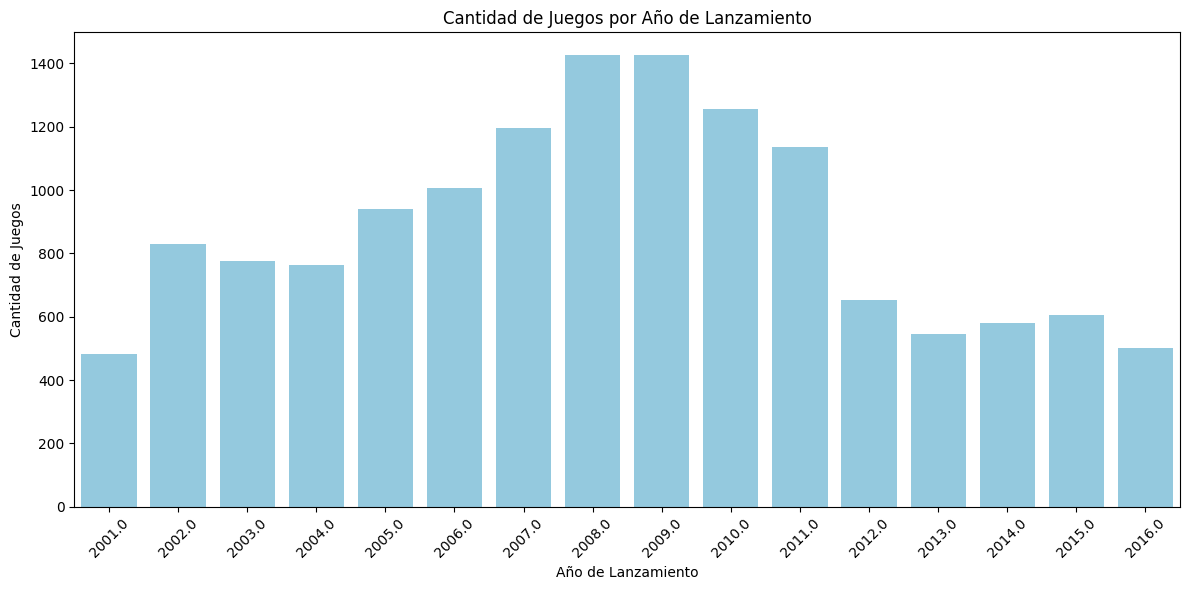

In [32]:

# Supongamos que df_games ya está cargado y tiene la columna 'year_of_release'
# Obtener los conteos ordenados por año
conteos = df_games['year_of_release'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=conteos.index, y=conteos.values, color="skyblue")

plt.xlabel("Año de Lanzamiento")
plt.ylabel("Cantidad de Juegos")
plt.title("Cantidad de Juegos por Año de Lanzamiento")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Observaremos cómo varían las ventas de una plataforma a otra. Eligiremos las plataformas con las mayores ventas totales y construiremos una distribución basada en los datos de cada año. Buscacaremos las plataformas que solían ser populares pero que ahora no tienen ventas. ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?

<Axes: xlabel='platform'>

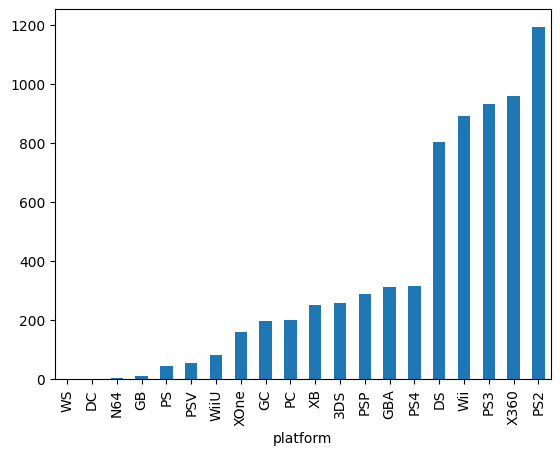

In [33]:
df_games.groupby('platform', observed=True)['total_sales'].sum().sort_values().plot(kind='bar') # ventas totales por pltaforma ordenados de menor a mayor

In [34]:
top_4=df_games.groupby('platform', observed=True)['total_sales'].sum().nlargest(4).index # top 4 de plataformas segun las ventas totales
top_4

CategoricalIndex(['PS2', 'X360', 'PS3', 'Wii'], categories=['3DS', 'DC', 'DS', 'GB', ..., 'WiiU', 'X360', 'XB', 'XOne'], ordered=False, dtype='category', name='platform')

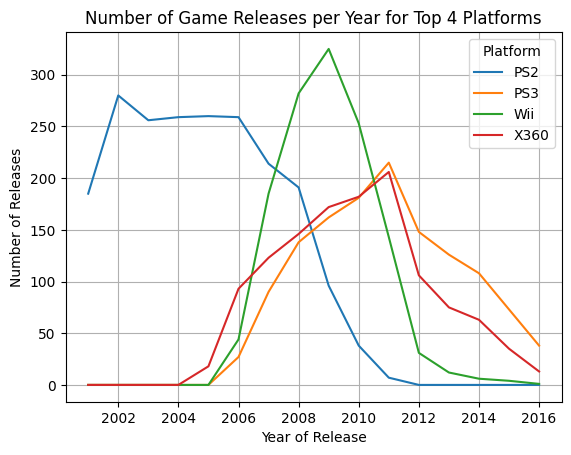

In [35]:
#graficamos el desempeño de las top 4 plataformas segun ventas totales
(
    df_games[df_games['platform'].isin(top_4)]
    .groupby(['year_of_release', 'platform'],observed = True)
    .size()
    .unstack(fill_value=0)
    .plot()  
)

# Añadimos etiquetas y título
plt.xlabel('Year of Release')
plt.ylabel('Number of Releases')
plt.title('Number of Game Releases per Year for Top 4 Platforms')
plt.legend(title='Platform')
plt.grid(True)
plt.show()


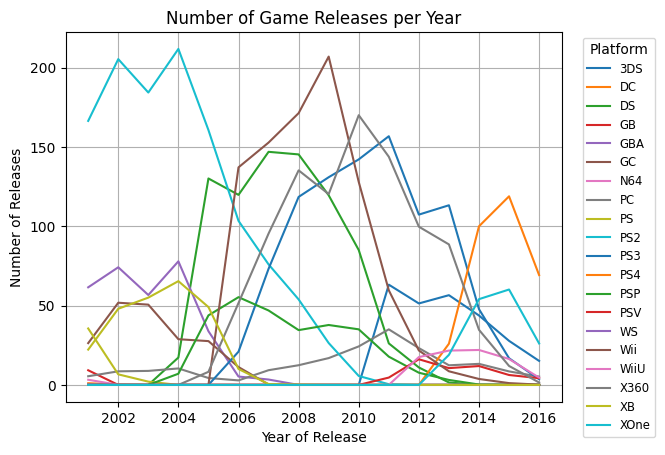

In [36]:
#Graficamos el desempeo de todas las plataformas 
df_games.groupby(['year_of_release','platform'], observed=True)['total_sales'].sum().unstack(fill_value=0).plot()

# Añadimos etiquetas y título
plt.xlabel('Year of Release')
plt.ylabel('Number of Releases')
plt.title('Number of Game Releases per Year')
plt.legend(title='Platform', loc='upper right', fontsize='small', ncol=1, bbox_to_anchor=(1.20, 1))
plt.grid(True)
plt.show()

In [37]:
# Plataformas mas populares 
most_popular = (
    df_games
    .groupby(['year_of_release','platform'], observed=True)['total_sales']
    .sum()
    .nlargest(5)
    .unstack()
    .columns
    .to_list()
    )
most_popular

['PS2', 'Wii']

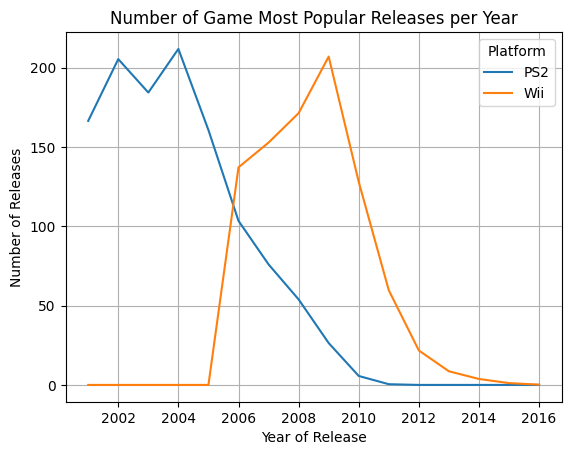

In [38]:
#Graficamos las plataformas populares top 3
(
    df_games[df_games['platform'].isin(most_popular)]
    .groupby(['year_of_release','platform'], observed=True)['total_sales']
    .sum()
    .unstack(fill_value=0)
    .plot()    
)

# Añadimos etiquetas y título
plt.xlabel('Year of Release')
plt.ylabel('Number of Releases')
plt.title('Number of Game Most Popular Releases per Year')
plt.legend(title='Platform')
plt.grid(True)
plt.show()


Respuesta:
- Como vemos para las 4 plataformas mas vendidas hasta el 2014, tenemos que la PS2 tuvo su pico maximo en 2004, las otras 3 tuvo su pico maximo entre 2008 y 2011.
- Podemos ver las 3 plataformas mas populares entre 2004 y 2010 en su momento hasta no tener ventas en 2014
- Como vemos ninguna plataforma se sostiene mas de 10 años entre las populares, es mas todas tienden a minimas ventas luego de una 10 años.

#### Determinaremos para qué período debes tomar datos. Para hacerlo mira tus respuestas a las preguntas anteriores. Los datos deberían permitirte construir un modelo para 2017.

Respuesta:
- Considerando los resultados anteriores tomaremos los datos entre 2000 y 2014, ya que tienen la mayor concentracion de informacion

#### Trabaja solo con los datos que consideras relevantes. Ignora los datos de años anteriores.

In [39]:
df_games_2000 = df_games[(df_games['year_of_release']>=2000)].reset_index().drop('index',axis=1) # restringimos los datos apartir del 2000 en adelante
df_games_2000

,name,year_of_release,platform,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Mame Goma: Shiro to Kuro no Meikyuu,2012.0,3DS,Action,0.00,0.00,0.03,0.00,70.5,6.75,NaN,0.03
1,Funky Barn,2012.0,3DS,Simulation,0.07,0.03,0.00,0.01,68.0,5.85,NaN,0.11
2,Crayon Shin-chan: Arashi o Yobu Kasukabe Eiga ...,2014.0,3DS,Adventure,0.00,0.00,0.06,0.00,81.0,8.75,NaN,0.06
3,The LEGO Movie Videogame,2014.0,3DS,Action,0.28,0.31,0.05,0.05,63.5,5.40,E10+,0.69
4,Professor Layton and the Mask of Miracle,2011.0,3DS,Puzzle,0.32,0.97,0.36,0.13,80.0,8.20,NaN,1.78
...,...,...,...,...,...,...,...,...,...,...,...,...
14115,Lego Star Wars: The Force Awakens,2016.0,XOne,Action,0.14,0.13,0.00,0.02,76.0,7.00,E10+,0.29
14116,Psycho-Pass,2014.0,XOne,Adventure,0.00,0.00,0.01,0.00,71.5,7.40,NaN,0.01
14117,Forza Horizon 3,2016.0,XOne,Racing,0.42,0.58,0.00,0.08,91.0,7.40,E,1.08
14118,Batman: Return to Arkham,2016.0,XOne,Action,0.05,0.05,0.00,0.01,77.0,8.20,T,0.11



#### ¿Qué plataformas son líderes en ventas? ¿Cuáles crecen y cuáles se reducen? Elige varias plataformas potencialmente rentables.

In [40]:
most_values = df_games_2000.groupby(['platform'], observed=True)['total_sales'].sum().sort_values().nlargest(5).index.to_list() # las 5 Plataformas mas valoradas

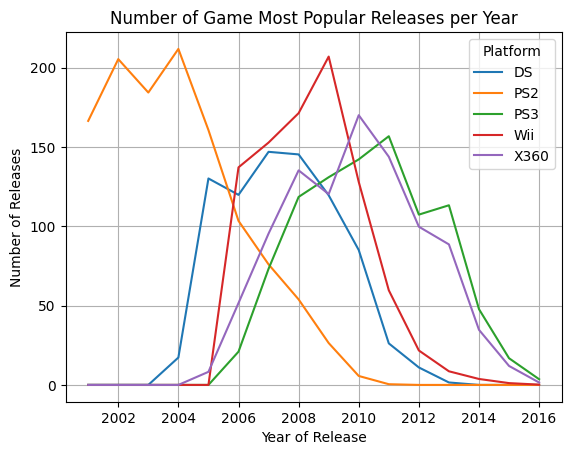

In [41]:
(
    df_games_2000[df_games_2000['platform'].isin(most_values)]
    .groupby(['year_of_release','platform'], observed=True)['total_sales']
    .sum()
    .unstack(fill_value=0)
    .plot()    
)

# Añadimos etiquetas y título
plt.xlabel('Year of Release')
plt.ylabel('Number of Releases')
plt.title('Number of Game Most Popular Releases per Year')
plt.legend(title='Platform')
plt.grid(True)
plt.show()

Respuesta:
- Todas las plataformas que tienen mayores ventas, para 2015 se van a 0 ventas, esto se debe a que se deja de sacar videojuegos de los plataformas ya pasadas de moda. como el PS2 , luego PS3 y paso a PS4 finalmente y ahora PS5.

#### Crearemos un diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma. ¿Son significativas las diferencias en las ventas? ¿Qué sucede con las ventas promedio en varias plataformas? Describe tus hallazgos.

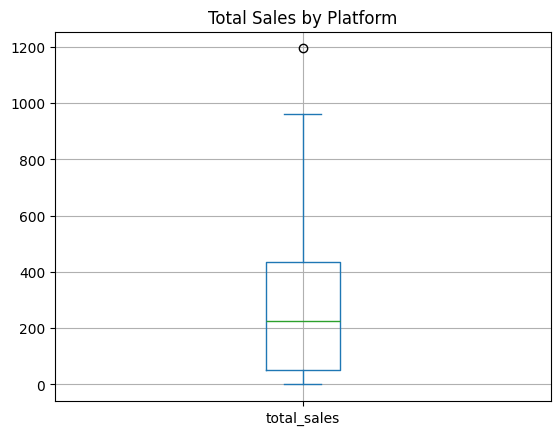

In [42]:
#Creamos un boxplot de las plataformas para las ventas totales
(
    df_games_2000
    .groupby('platform',observed=True)['total_sales']
    .sum()
    .plot(
        kind='box',
        title='Total Sales by Platform',
        grid=True)   
)

# Mostrar el box plot
plt.show()

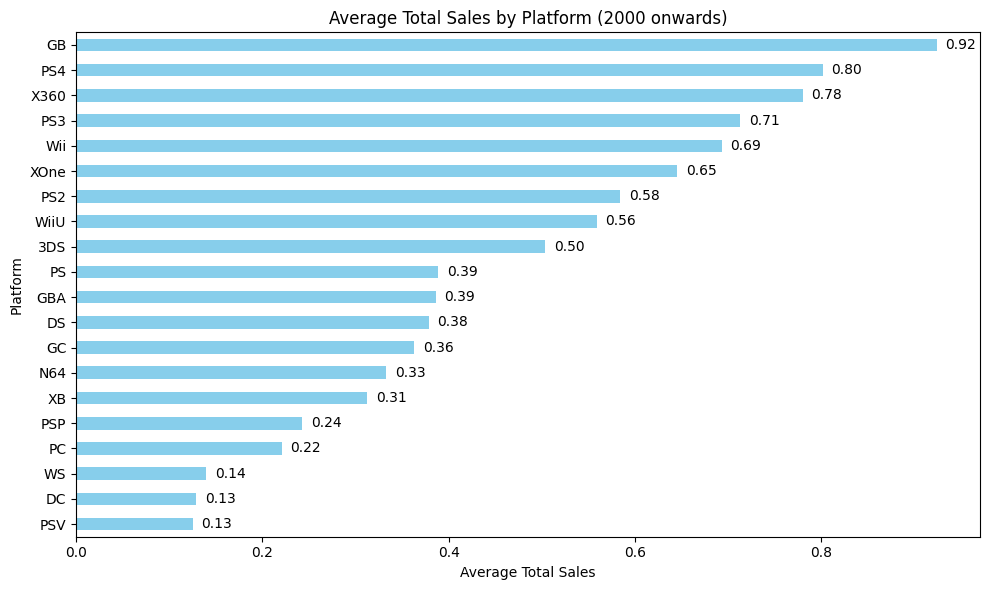

In [ ]:
# Calcular el promedio de ventas totales por plataforma
platform_sales_avg = (
    df_games_2000
    .groupby('platform', observed=True)['total_sales']
    .mean()
)

# Ordenar los valores de menor a mayor
sorted_sales = platform_sales_avg.sort_values()

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 6))
ax = sorted_sales.plot(kind='barh', color='skyblue')
plt.xlabel('Average Total Sales')
plt.ylabel('Platform')
plt.title('Average Total Sales by Platform (2000 onwards)')
plt.tight_layout()

# Agregar anotaciones al lado de cada barra
# Se usa un margen relativo al valor máximo para posicionar el texto
margin = 0.01 * sorted_sales.max()
for i, value in enumerate(sorted_sales):
    ax.text(value + margin, i, f"{value:.2f}", color='black', va='center')

plt.show()


In [117]:
# comportamiento de las ventas totales de las paltaformas para los diferentes años.
df_games_2 = (
    df_games_2000
    .groupby(['year_of_release','platform'],observed=True)['total_sales']
    .mean()
    .unstack()
    .sort_index(axis=1)
)
df_games_2

platform,3DS,DC,DS,GB,GBA,GC,N64,PC,PS,PS2,PS3,PS4,PSP,PSV,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,
2001.0,NaN,0.13375,NaN,0.924,0.575047,1.197273,0.361111,0.364667,0.391099,0.899622,NaN,NaN,NaN,NaN,0.14,NaN,NaN,NaN,0.674545,NaN
2002.0,NaN,0.29000,NaN,NaN,0.374545,0.340855,0.080000,0.451053,0.333500,0.733500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.303861,NaN
2003.0,NaN,NaN,NaN,NaN,0.377800,0.351458,NaN,0.267879,0.690000,0.719961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.291217,NaN
2004.0,NaN,NaN,0.750870,NaN,0.445200,0.347229,NaN,0.346333,NaN,0.817799,NaN,NaN,0.470667,NaN,NaN,NaN,NaN,NaN,0.369605,NaN
2005.0,NaN,NaN,1.102881,NaN,0.250815,0.284742,NaN,0.118108,NaN,0.617923,NaN,NaN,0.461474,NaN,NaN,NaN,NaN,0.458333,0.274190,NaN
2006.0,NaN,NaN,0.596070,NaN,0.135385,0.281500,NaN,0.054808,NaN,0.399305,0.776296,NaN,0.292698,NaN,NaN,3.117045,NaN,0.555054,0.161935,NaN
2007.0,NaN,0.02000,0.390798,NaN,0.566667,0.067500,NaN,0.149677,NaN,0.355093,0.813222,NaN,0.352857,NaN,NaN,0.825784,NaN,0.775691,0.183333,NaN
2008.0,NaN,0.04000,0.295346,NaN,NaN,NaN,NaN,0.163421,NaN,0.282199,0.858841,NaN,0.345500,NaN,NaN,0.607518,NaN,0.926438,0.180000,NaN
2009.0,NaN,NaN,0.296625,NaN,NaN,NaN,NaN,0.158037,NaN,0.275000,0.808210,NaN,0.234658,NaN,NaN,0.636831,NaN,0.699360,NaN,NaN


<Figure size 1000x600 with 0 Axes>

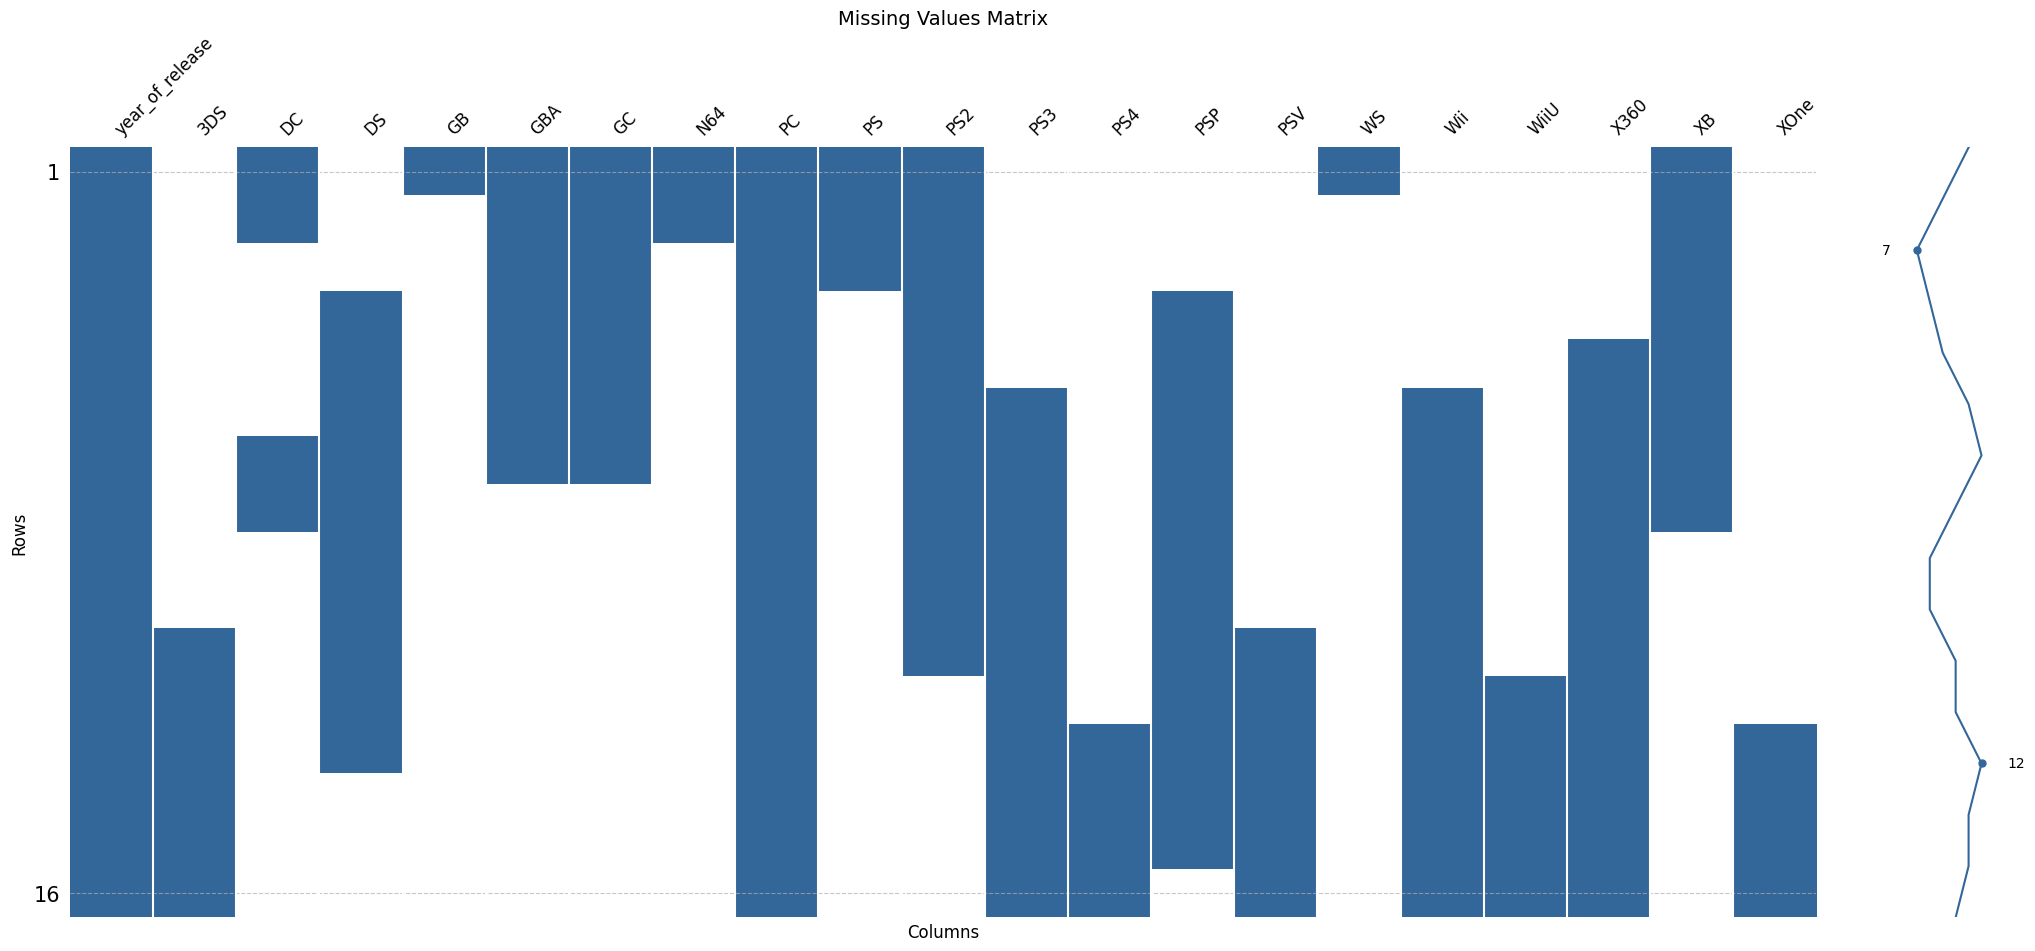

In [123]:
# Agrupar por 'year_of_release' y 'platform' y calcular el promedio de 'total_sales'

plot_missing_values_matrix(df_games_2.reset_index(),sort_columns=True)

Respuesta:
- Como vemos en los datos PS, PS2, PS3 y PS4, podemos apreciar que las ventas comparten 3 a 5 años con la nueva version y dejan de tener ventas llevandoselo todo la siguiente version de la plataforma.
- Lo mismo ocurre con el Wii y el Wiiu
- Lo mismo con XB, X360 y XOne
- Lo mismo con PSP y PSV
- Tenemos que destacar que la unica plataforma que tiene ventas todos los años es PC.
- Podemos considerar esta informacion para realizar imputaciones.

#### Veamos cómo las reseñas de usuarios y profesionales afectan las ventas de una plataforma popular (tu elección). Crea un gráfico de dispersión y calcula la correlación entre las reseñas y las ventas.

In [46]:

# verificar relaciones discriminado por genero
(
    smf.ols(
        formula='total_sales ~ critic_score + user_score',
        data=df_games_2000[df_games_2000['platform']=='PC']
        #data=df
    )
    .fit()
    .summary()
    .tables[0]
)


Dep. Variable:,total_sales,R-squared:,0.086
Model:,OLS,Adj. R-squared:,0.084
Method:,Least Squares,F-statistic:,42.77
Date:,"Tue, 11 Feb 2025",Prob (F-statistic):,1.78e-18
Time:,20:24:27,Log-Likelihood:,-765.07
No. Observations:,910,AIC:,1536.
Df Residuals:,907,BIC:,1551.
Df Model:,2,,
Covariance Type:,nonrobust,,


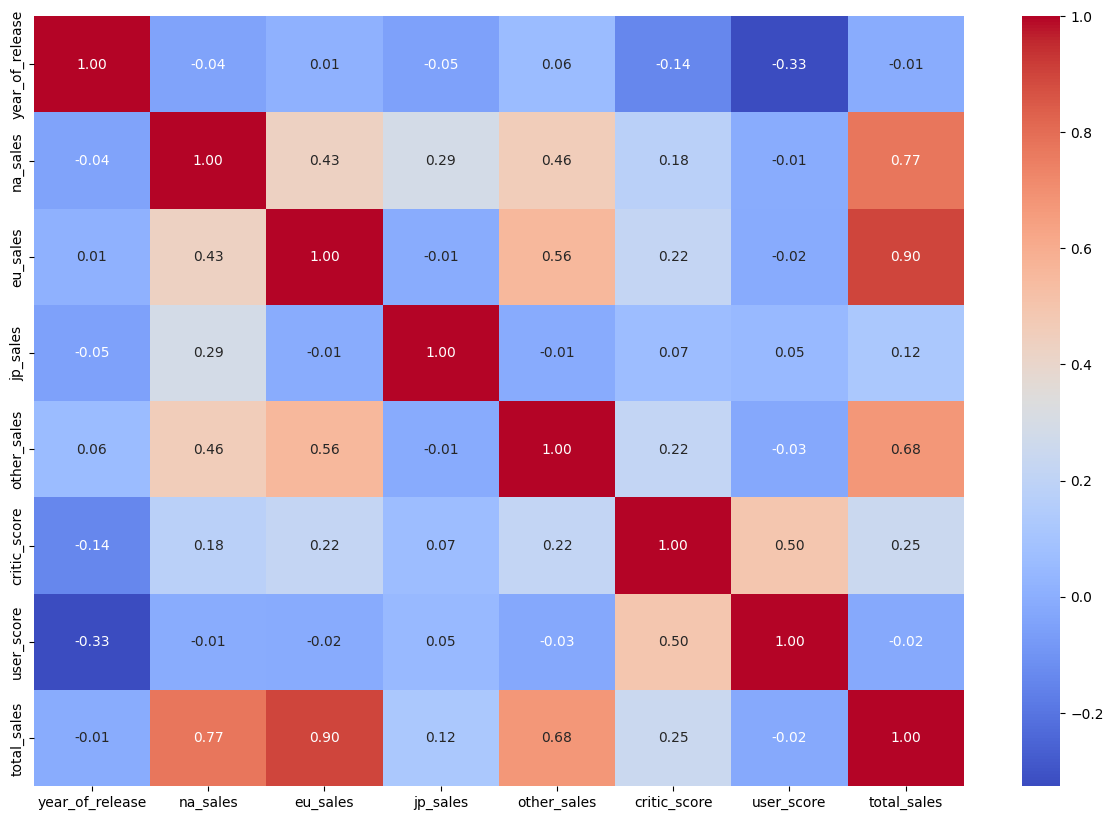

In [124]:
# Graficamos relaciones con una matrix de correlacion para unicamente la platamfor PC

matrix_correlation(df_games_2000[df_games_2000['platform']=='PC'].select_dtypes(exclude=['category','object','datetime']), figsize=(15,10))


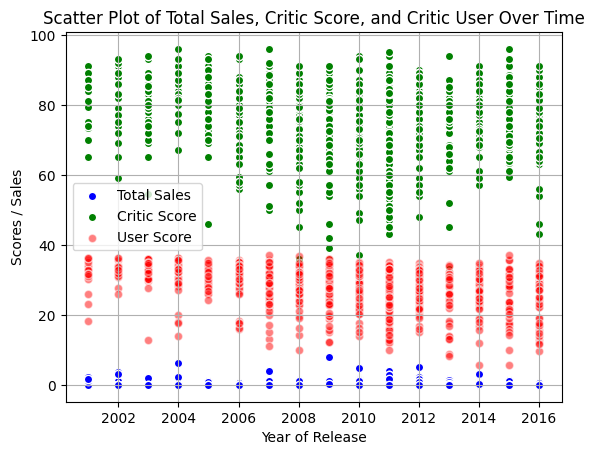

In [48]:
#Comparacion con grafico de dispersion de total sales, critic score y user score atraves de los años
# usaremos cambio de escala a x4 para user_score
# grafico solo para ver relaciones

df_scatter = df_games_2000[df_games_2000['platform']=='PC']

plt.scatter(df_scatter['year_of_release'], df_scatter['total_sales'], color='blue', label='Total Sales', alpha=1, edgecolors='w')
plt.scatter(df_scatter['year_of_release'], df_scatter['critic_score'], color='green', label='Critic Score', alpha=1, edgecolors='w')
plt.scatter(df_scatter['year_of_release'], df_scatter['user_score']*4, color='red', label='User Score', alpha=0.5, edgecolors='w')  # incrmento de escala por 4 para facilidad de lectura

plt.xlabel('Year of Release')
plt.ylabel('Scores / Sales')
plt.title('Scatter Plot of Total Sales, Critic Score, and Critic User Over Time')
plt.legend()
plt.grid(True)

Respuesta:
- Como podemos ver para la plataforma escogida PC no hay una relacion clara entre critic_score, user_score vs total_sales, los picos de score no estan acompañados de picos en ventas.
- Como vimos las corerlaciones tambien indican que no hay una correlacion significativa.

#### Compara las ventas de los mismos juegos en otras plataformas.

In [49]:
df_games_2000.groupby(['name'])['platform'].count().sort_values(ascending=False) # Juegos iguales en diferentes plataformas

name
Need for Speed: Most Wanted     12
FIFA 14                          9
Ratatouille                      9
LEGO Marvel Super Heroes         9
Madden NFL 07                    8
                                ..
.hack//G.U. Vol.2//Reminisce     1
.hack//G.U. Vol.1//Rebirth       1
 Tales of Xillia 2               1
 Haikyu!! Cross Team Match!      1
 Fire Emblem Fates               1
Name: platform, Length: 9405, dtype: int64

In [50]:
juego_1 = df_games_2000.groupby(['name'])['platform'].count().sort_values(ascending=False).index[0] # escogemos 'LEGO Star Wars II: The Original Trilogy'
df_games[df_games['name']== 'LEGO Star Wars II: The Original Trilogy']

,name,year_of_release,platform,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2330,LEGO Star Wars II: The Original Trilogy,2006.0,DS,Action,0.96,0.03,0.00,0.08,47.0,5.0,E,1.07
3034,LEGO Star Wars II: The Original Trilogy,2006.0,GBA,Action,0.06,0.02,0.00,0.00,55.0,7.0,E,0.08
3974,LEGO Star Wars II: The Original Trilogy,2006.0,GC,Action,0.75,0.19,0.00,0.03,84.0,9.1,E10+,0.97
4451,LEGO Star Wars II: The Original Trilogy,2006.0,PC,Action,0.00,0.01,0.00,0.00,86.0,8.2,E10+,0.01
6284,LEGO Star Wars II: The Original Trilogy,2006.0,PS2,Action,1.85,0.64,0.01,0.19,84.0,9.0,E10+,2.69
9931,LEGO Star Wars II: The Original Trilogy,2006.0,PSP,Action,0.58,0.50,0.00,0.32,83.0,8.6,E10+,1.40
12424,LEGO Star Wars II: The Original Trilogy,2006.0,X360,Action,0.55,0.03,0.00,0.05,81.0,8.0,E10+,0.63
13831,LEGO Star Wars II: The Original Trilogy,2006.0,XB,Action,0.33,0.10,0.00,0.02,85.0,8.6,E10+,0.45


Respuesta:
- Los titulos que salieron en varias plataformas no tienen mucha data historica.
- Como podemos ver en este caso para 'LEGO Star Wars II: The Original Trilogy'
- Pero como hemos visto anteriomente los juegos de las plataformas mas recientes son siempre las que tienen mayores ventas

#### Echemos un vistazo a la distribución general de los juegos por género. ¿Qué se puede decir de los géneros más rentables? ¿Puedes generalizar acerca de los géneros con ventas altas y bajas?

In [51]:
# Comparacion de ventas totales para los diferentes generos
(
    df_games_2000
    .groupby(['genre'],observed=False)
    .agg(
        total_sales_count=('total_sales', 'count'),
        total_sales_sum=('total_sales', 'sum'),
        total_sales_mean=('total_sales', 'mean')
        )
    .sort_values(by='total_sales_sum', ascending=False)
)


,total_sales_count,total_sales_sum,total_sales_mean
genre,,,
Action,3035,1492.18,0.491657
Sports,1898,1089.68,0.574120
Shooter,1109,905.87,0.816835
Misc,1577,702.80,0.445656
Role-Playing,1271,702.17,0.552455
Racing,992,541.06,0.545423
Platform,696,478.37,0.687313
Simulation,753,332.04,0.440956
Fighting,611,291.64,0.477316


Respuesta:
- Podemos ver que los generos mas vendidos son Action, Sports y Shooter, en general.
- Podemos ver que en promedio los mas rentables serian los Misc, Shooter y Plaform.
- Considerando esto podriamos decir que el genero Shooter es el mas efectivo en funcion de 'total_sales'

### Analisis por Regiones

#### Para cada región (NA, UE, JP) determina:
### Las cinco plataformas principales. Describe las variaciones en sus cuotas de mercado de una región a otra.

In [52]:
#Tomaremos las 5 plataformas mas importantes en cuanto a ventas totales
top_5_platform = df_games_2000.groupby('platform',observed=False)['total_sales'].sum().sort_values(ascending=False).nlargest(5).index.to_list()
top_5_platform

['PS2', 'X360', 'PS3', 'Wii', 'DS']

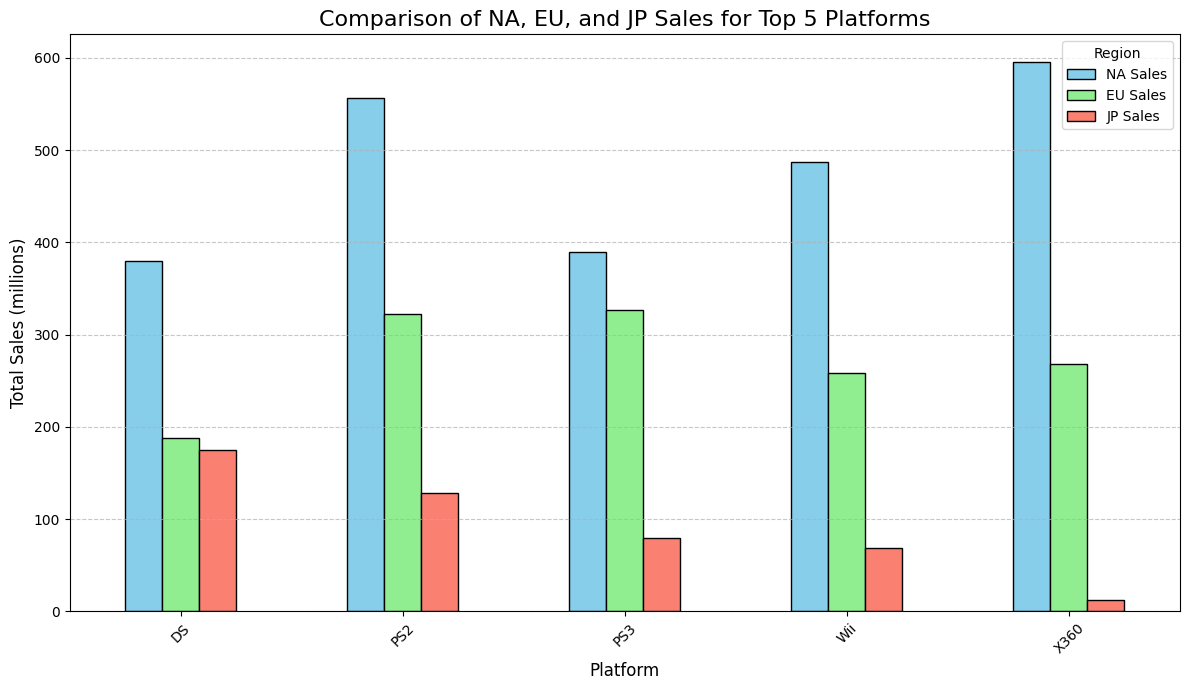

In [53]:
# Comparación de ventas con barras separadas por región

# Filtrar y agrupar los datos
platform_sales_comparison = (
    df_games_2000[df_games_2000['platform'].isin(top_5_platform)]
    .groupby('platform', observed=True)
    .agg(
        total_na_sales=('na_sales', 'sum'),
        total_eu_sales=('eu_sales', 'sum'),
        total_jp_sales=('jp_sales', 'sum')
    )
    .reset_index()
    .sort_values('platform', ascending=True)
)

# Grafico con barras separadas
platform_sales_comparison.plot(
    x='platform', 
    kind='bar', 
    color=['skyblue', 'lightgreen', 'salmon'], 
    figsize=(12, 7),
    edgecolor='black'
)

plt.title('Comparison of NA, EU, and JP Sales for Top 5 Platforms', fontsize=16, loc='center')
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Total Sales (millions)', fontsize=12)
plt.legend(['NA Sales', 'EU Sales', 'JP Sales'], title='Region', fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Respuesta:
- Como vemos para las plataformas el mercado Norteamericano es ampliamente el mayor consumidor, sobre todo la X360.


Los cinco géneros principales. Explica la diferencia.
Si las clasificaciones de ESRB afectan a las ventas en regiones individuales.

In [54]:
#Tomaremos las 5 generos mas importantes en cuanto a ventas totales

top_5_genre = df_games_2000.groupby('genre',observed=False)['total_sales'].sum().sort_values(ascending=False).nlargest(5).index.to_list()
top_5_genre

['Action', 'Sports', 'Shooter', 'Misc', 'Role-Playing']

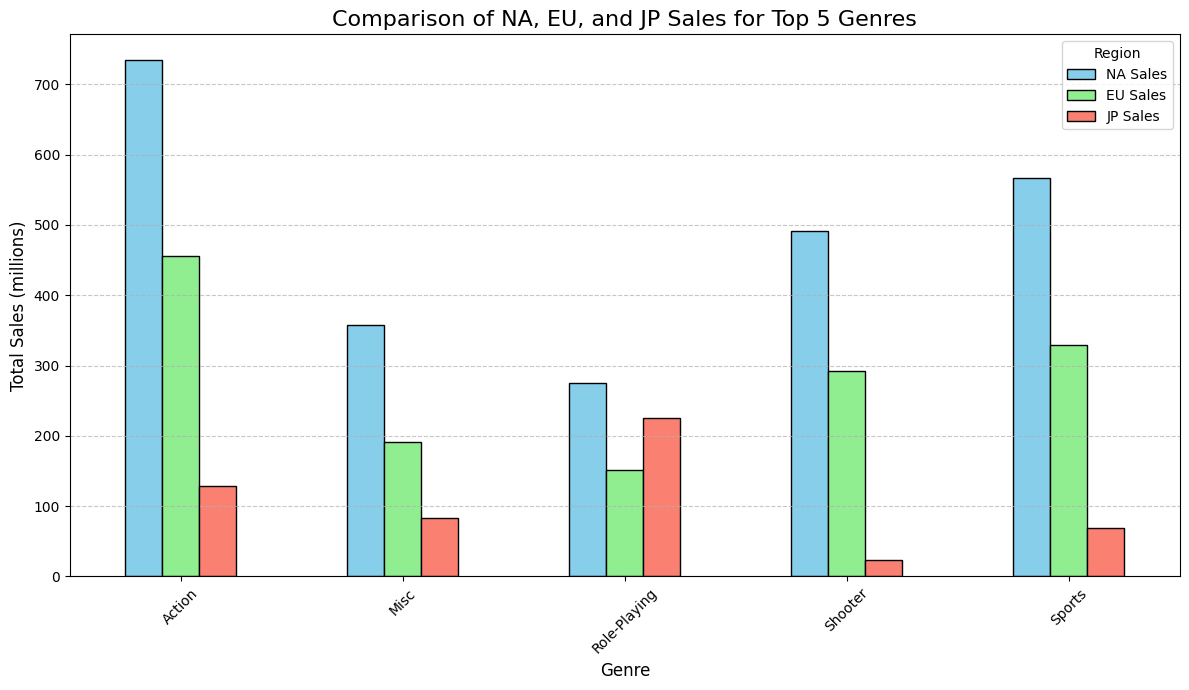

In [55]:
# Comparación de ventas para los 5 géneros principales con barras separadas por región

# Filtrar y agrupar los datos
genre_sales_comparison = (
    df_games_2000[df_games_2000['genre'].isin(top_5_genre)]
    .groupby('genre', observed=True)
    .agg(
        total_na_sales=('na_sales', 'sum'),
        total_eu_sales=('eu_sales', 'sum'),
        total_jp_sales=('jp_sales', 'sum')
    )
    .reset_index()
    .sort_values('genre', ascending=True)
)

# Gráfico con barras separadas por región
genre_sales_comparison.plot(
    kind='bar', 
    x='genre',
    color=['skyblue', 'lightgreen', 'salmon'], 
    figsize=(12, 7),
    edgecolor='black'
)

plt.title('Comparison of NA, EU, and JP Sales for Top 5 Genres', fontsize=16, loc='center')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Total Sales (millions)', fontsize=12)
plt.legend(['NA Sales', 'EU Sales', 'JP Sales'], title='Region', fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Respuesta:
- Como vemos para las generos vemos que el mercado Norteamericano es ampliamente el mayor consumidor, sobre todo el genero de Action.

#### Analisis Estadistico
Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

<Figure size 800x600 with 0 Axes>

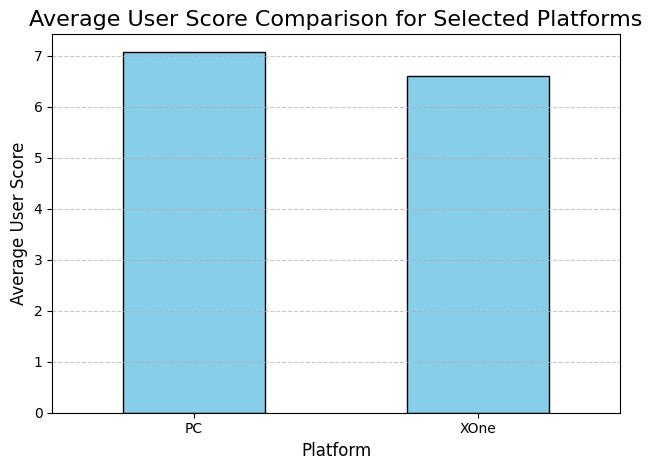

In [56]:
# Comparación de promedios de puntuación de usuario para dos plataformas

# Selección de plataformas
platf_select = ['PC', 'XOne']

# Filtrar y calcular los promedios
df_plat_mean = (
    df_games_2000
    .groupby('platform', observed=True)['user_score']
    .mean()
    .reset_index()
    .set_index('platform')
    .loc[platf_select]
)

# Crear el gráfico
plt.figure(figsize=(8, 6))
df_plat_mean.plot(
    kind='bar', 
    color='skyblue', 
    legend=False, 
    edgecolor='black'
)

# Personalizar el gráfico
plt.title('Average User Score Comparison for Selected Platforms', fontsize=16, loc='center')
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Average User Score', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

###  Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

<Figure size 800x600 with 0 Axes>

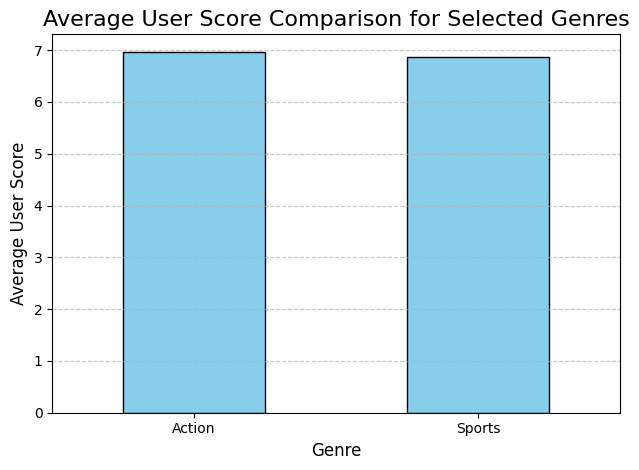

In [57]:
# Gráfico de comparación de promedios de puntuación de usuario para dos géneros

# Selección de géneros
genre_select = ['Action', 'Sports']

# Filtrar y calcular los promedios
df_genre_mean = (
    df_games_2000
    .groupby('genre', observed=True)['user_score']
    .mean()
    .reset_index()
    .set_index('genre')
    .loc[genre_select]
)

# Crear el gráfico
plt.figure(figsize=(8, 6))
df_genre_mean.plot(
    kind='bar', 
    color='skyblue', 
    legend=False, 
    edgecolor='black'
)

# Personalizar el gráfico
plt.title('Average User Score Comparison for Selected Genres', fontsize=16, loc='center')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average User Score', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()



#### Establecemos tu mismo el valor de umbral alfa y realizamos la prueba de hipotesis
#### Explica:

* Cómo formulaste las hipótesis nula y alternativa.
* Qué criterio utilizaste para probar las hipótesis y por qué.

In [58]:
# Hipotesis Nula son iguales estadisticamente
aplha = 0.05
platform_1 = df_games_2000[df_games_2000['platform'] == 'XOne']['user_score']
platform_2 = df_games_2000[df_games_2000['platform'] == 'PC']['user_score']

results = stats.ttest_ind(platform_1, platform_2)

# Imprimir el valor p resultante
print('valor p: ', results.pvalue)

if( results[1] <= aplha):
    print(' Rechazamos la hipotesis nula') 
else:
    print('No podemos rechazar la hipotesis nula')


valor p:  3.21853977802195e-06
 Rechazamos la hipotesis nula


In [59]:
# Hipotesis Nula son iguales estadisticamente
aplha = 0.05
genre_1 = df_games_2000[df_games_2000['genre'] == 'Action']['user_score']
genre_2 = df_games_2000[df_games_2000['genre'] == 'Sports']['user_score']

results = stats.ttest_ind(genre_1, genre_2)

# imprimir el valor p resultante
print('valor p: ', results.pvalue)

if( results[1] <= aplha):
    print(' Rechazamos la hipotesis nula') 
else:
    print('No podemos rechazar la hipotesis nula')

valor p:  0.04900814718661064
 Rechazamos la hipotesis nula


Respuesta:
- Vemos las comparaciones en promedio en las graficas de las alternativas para genero y plataforma.
- Hacemos 2 comparaciones utilizando el ttest.ind() que nos sirve para comparar 2 poblaciones y determinar si hay evidencia significativa de que las medias de los dos grupos son diferentes usando la hipotesis nula y la hipotesis alternativa.
- Determinamos que para la primera comparacion entre XOne y PC, tenemos un rechazo de la hipotesis nula, es decir no tenemos evidencia significativa que las medias de los dos grupos son iguales, y como vemos en el grafico son valores distintos
- Determinamos que para la primera comparacion entre Action y Sports, tenemos un no podemos rechazar la hipotesis nula, es decir si tenemos evidencia significativa que las medias de los dos grupos son iguales, y como vemos en el grafico son valores casi iguales.

### Conclusiones

Respuesta:
- Hemos encontrado que los juegos son sacados para las distintas plataformas pero estos no duran mucho tiempo en el mercado ya que las plataformas se van actualizando.
- Hemos encontrado que conforme las plataformas van cambiando los usuarios obtan por dejar la version anterior y pasar la siguiente version.
- Hemos encontrado que la unica paltaforma que ha permanecido con ventas constantes en la PC, esto porque las PC pueden repotenciarse o cambiarse pero al cambiarse de PC sigue siendo etiquetado como PC.
- Hemos encontrado que antes del 2000 no se contaba con un registro oportuno de informacion o simplemente no era habitual establecer una score de usuarios y un score de la critic.
- Hemos entendido que la mayoria de valores nulos pueden ser imputados restringiendo dsde el 2000 hacia adelante.
- Hemos establecido con evidencia significativa la comparacion de las poblaciones de XOne y PC.
- Hemos establecido con evidencia significativa la comparacion de las poblaciones de los generos Action y Sports
- Intentaremos realizar imputaciones con todo lo aprendido sobre los datos.